# Vision-Based Robotic Grasp Detection using Deep Learning on the Cornell Dataset

**Project Goals:**
This project aims to develop a deep learning model for vision-based robotic grasp detection. The primary goal is to enable a robot to autonomously identify optimal grasp positions, orientations, and widths for objects from RGB-D images. We will be using the Cornell Grasping Dataset and implementing GG-CNN style models.

# 1. Initial Imports and Dataset Load

In [1]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib
import yaml
import PIL
import shapely

import sys
import math
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import json
from tqdm.notebook import tqdm # Use notebook version for better display in Jupyter

# Print all versions of relevant packages for debugging
print(f"Python: {sys.version}")
print(f"Torch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"PyYAML: {yaml.__version__}")
print(f"Pillow (PIL): {PIL.__version__}")
print(f"Shapely: {shapely.__version__}")

Python: 3.11.12 (main, May 10 2025, 17:44:43) [Clang 17.0.0 (clang-1700.0.13.3)]
Torch: 2.7.0
Torchvision: 0.22.0
OpenCV: 4.11.0
NumPy: 2.0.2
Matplotlib: 3.10.0
PyYAML: 6.0.2
Pillow (PIL): 11.2.1
Shapely: 2.1.0


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = Path('/content/drive/MyDrive/DLR_Final_Proj/data/')
except ModuleNotFoundError:
    DATA_PATH = Path('data/')

def load_grasps(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        points = [list(map(float, line.strip().split())) for line in lines]
        grasps = [points[i:i+4] for i in range(0, len(points), 4)]
    return grasps

# Example file for testing
test_file = DATA_PATH / '01' / 'pcd0100cpos.txt'
positive_grasps = load_grasps(test_file)
print(f"Loaded {len(positive_grasps)} positive grasps from {test_file.name}")
print("First grasp rectangle (4 corners):")
print(positive_grasps[0])

Loaded 4 positive grasps from pcd0100cpos.txt
First grasp rectangle (4 corners):
[[253.0, 319.7], [309.0, 324.0], [307.0, 350.0], [251.0, 345.7]]


In [3]:
RANDOM_SEED = 42
OUTPUT_IMG_SIZE = (224, 224)  # Tuple (height, width) for model input and map output
TEST_SET_FRACTION = 0.1
VALIDATION_SET_FRACTION = 0.2 # Fraction of the (total - test) data

BATCH_SIZE = 16               # Batch size for DataLoaders
NUM_WORKERS = 0               # Number of workers for DataLoaders (0 for MPS initial stability)

ORIGINAL_IMG_SHAPE_HW = (480, 640) # Input image shape (height, width)
OUTPUT_IMG_SIZE = (224, 224) # Output image shape (height, width)
MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED = 40.0 # For normalizing target width map values to [0,1]


def get_device():
    if torch.cuda.is_available():
        print("CUDA (NVIDIA GPU) is available.")
        return torch.device("cuda")
    # Check for MPS (Apple Silicon GPU)
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("MPS (Apple Silicon GPU) is available.")
        return torch.device("mps")
    else:
        print("No GPU acceleration (CUDA or MPS) available, using CPU.")
        return torch.device("cpu")

DEVICE = get_device()
print(f"Using device: {DEVICE}")

def set_random_seeds(seed_value=RANDOM_SEED):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if DEVICE.type == 'cuda': # Only seed CUDA if it's actually being used
        torch.cuda.manual_seed_all(seed_value)

set_random_seeds()
print(f"Global random seeds set with value: {RANDOM_SEED}")


if 'DATA_PATH' in locals() and DATA_PATH is not None: # Ensure DATA_PATH is defined
    PREPROCESSED_DATA_DIR = DATA_PATH.parent / 'preprocessed_ggcnn'
    try:
        os.makedirs(PREPROCESSED_DATA_DIR, exist_ok=True)
        print(f"Preprocessed data will be stored in/loaded from: {PREPROCESSED_DATA_DIR}")
    except Exception as e:
        print(f"Error creating PREPROCESSED_DATA_DIR '{PREPROCESSED_DATA_DIR}': {e}")
        print("Please check permissions or path validity.")
        # Potentially raise the error or set PREPROCESSED_DATA_DIR to None to handle gracefully
        PREPROCESSED_DATA_DIR = None 
else:
    print("Warning: DATA_PATH not defined. PREPROCESSED_DATA_DIR cannot be set relative to it.")
    PREPROCESSED_DATA_DIR = None # Or handle as an error

# Check if PREPROCESSED_DATA_DIR was successfully created
if PREPROCESSED_DATA_DIR is None or not PREPROCESSED_DATA_DIR.exists():
    print(f"FATAL ERROR: PREPROCESSED_DATA_DIR ('{PREPROCESSED_DATA_DIR}') could not be established.")
    print("Further processing that relies on this directory will likely fail.")
    # Consider raising an error to stop execution if this directory is critical from the start.
    # raise OSError(f"Failed to create or access PREPROCESSED_DATA_DIR: {PREPROCESSED_DATA_DIR}")

MPS (Apple Silicon GPU) is available.
Using device: mps
Global random seeds set with value: 42
Preprocessed data will be stored in/loaded from: preprocessed_ggcnn


# 2. Data Exploration & Understanding

In [4]:
def list_object_folders(data_path):
    object_folders = []
    if data_path.exists() and data_path.is_dir():
        for item in sorted(data_path.iterdir()):
            if item.is_dir() and item.name.isdigit() and 0 < int(item.name) <= 10:
                object_folders.append(item.name)
    return object_folders

object_folders = list_object_folders(DATA_PATH)
print(f"Available object folders: {object_folders}")

Available object folders: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']


In [5]:
SAMPLE_FOLDER = '01'
SAMPLE_SCENE_ID = '0100' # Keep it as a string for f-string formatting

rgb_image_path = DATA_PATH / SAMPLE_FOLDER / f"pcd{SAMPLE_SCENE_ID}r.png"
depth_image_path = DATA_PATH / SAMPLE_FOLDER / f"pcd{SAMPLE_SCENE_ID}d.tiff"
cpos_path = DATA_PATH / SAMPLE_FOLDER / f"pcd{SAMPLE_SCENE_ID}cpos.txt"
cneg_path = DATA_PATH / SAMPLE_FOLDER / f"pcd{SAMPLE_SCENE_ID}cneg.txt"

# Load RGB Image
if rgb_image_path.exists():
    rgb_image = Image.open(rgb_image_path)
    rgb_image_np = np.array(rgb_image)
    print(f"Loaded RGB image: {rgb_image_path.name}, Shape: {rgb_image_np.shape}, Mode: {rgb_image.mode}")
else:
    print(f"RGB image not found: {rgb_image_path}")
    rgb_image_np = None

# Load Depth Image
if depth_image_path.exists():
    depth_image = Image.open(depth_image_path) # TIFF files are often 16-bit single channel
    depth_image_np = np.array(depth_image)
    print(f"Loaded Depth image: {depth_image_path.name}, Shape: {depth_image_np.shape}, Dtype: {depth_image_np.dtype}, Mode: {depth_image.mode}")
else:
    print(f"Depth image not found: {depth_image_path}")
    depth_image_np = None

# Load Positive Grasps (using the function you already have)
if cpos_path.exists():
    positive_grasps = load_grasps(cpos_path)
    print(f"Loaded {len(positive_grasps)} positive grasps from {cpos_path.name}")
else:
    print(f"Positive grasp file not found: {cpos_path}")
    positive_grasps = []

# Load Negative Grasps
if cneg_path.exists():
    negative_grasps = load_grasps(cneg_path)
    print(f"Loaded {len(negative_grasps)} negative grasps from {cneg_path.name}")
else:
    print(f"Negative grasp file not found: {cneg_path}")
    negative_grasps = []

Loaded RGB image: pcd0100r.png, Shape: (480, 640, 3), Mode: RGB
Loaded Depth image: pcd0100d.tiff, Shape: (480, 640), Dtype: float32, Mode: F
Loaded 4 positive grasps from pcd0100cpos.txt
Loaded 3 negative grasps from pcd0100cneg.txt


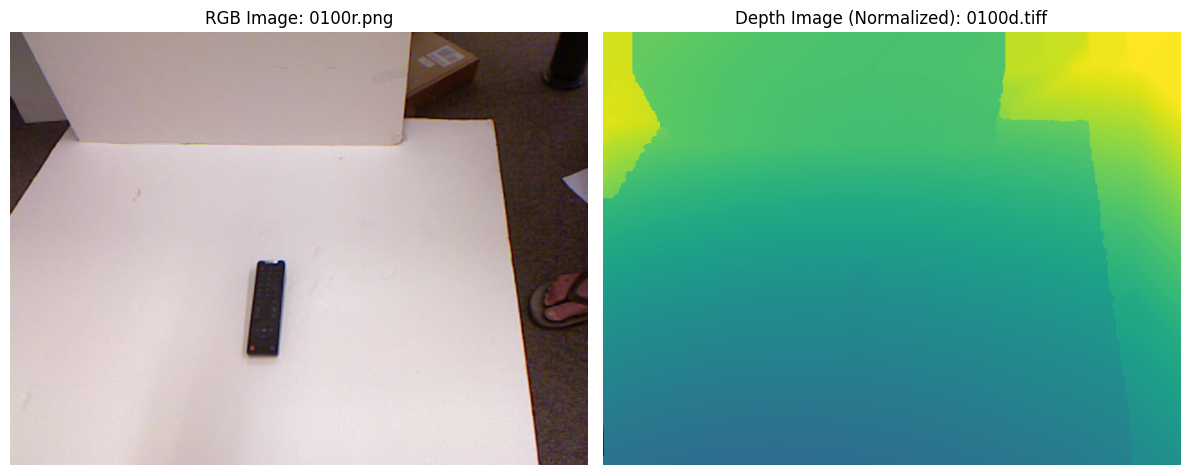

In [6]:
def normalize_depth_for_display(depth_array):
    if depth_array is None:
        return None
    depth_norm = depth_array.astype(np.float32) # Ensure float for division
    if depth_norm.max() > depth_norm.min(): # Avoid division by zero if depth is constant
        depth_norm = (depth_norm - depth_norm.min()) / (depth_norm.max() - depth_norm.min())
    else: # Handle constant depth (e.g., all zeros)
        depth_norm = np.zeros_like(depth_norm)
    return depth_norm

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

if rgb_image_np is not None:
    axes[0].imshow(rgb_image_np)
    axes[0].set_title(f"RGB Image: {SAMPLE_SCENE_ID}r.png")
    axes[0].axis('off')
else:
    axes[0].set_title("RGB Image Not Loaded")
    axes[0].axis('off')

if depth_image_np is not None:
    depth_display = normalize_depth_for_display(depth_image_np)
    axes[1].imshow(depth_display, cmap='viridis') # Or 'gray', 'plasma', etc.
    axes[1].set_title(f"Depth Image (Normalized): {SAMPLE_SCENE_ID}d.tiff")
    axes[1].axis('off')
else:
    axes[1].set_title("Depth Image Not Loaded")
    axes[1].axis('off')

plt.tight_layout()
plt.show()

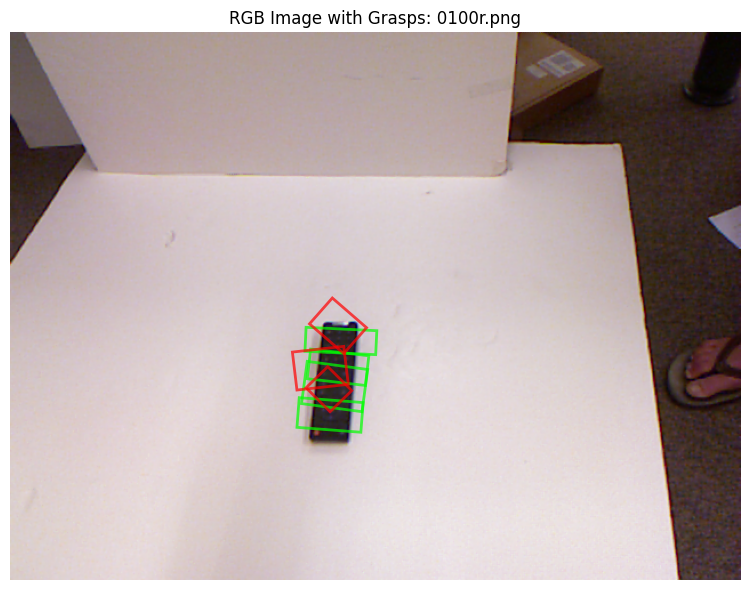

In [7]:
from matplotlib.patches import Polygon

def draw_grasp_rectangles(ax, grasps, color='g', linewidth=2, alpha=0.7):
    if grasps is None:
        return
    for grasp_points in grasps:
        if len(grasp_points) == 4: # Expecting 4 corner points
            poly = Polygon(grasp_points, closed=True, edgecolor=color, facecolor='none', 
                           linewidth=linewidth, alpha=alpha)
            ax.add_patch(poly)
        else:
            print(f"Warning: A grasp did not have 4 points: {grasp_points}")

# Display RGB image with grasp annotations
fig_grasps, ax_grasps = plt.subplots(figsize=(8, 6))

if rgb_image_np is not None:
    ax_grasps.imshow(rgb_image_np)
    
    # Draw positive grasps
    if positive_grasps:
        draw_grasp_rectangles(ax_grasps, positive_grasps, color='lime', linewidth=2) # Lime green for better visibility
    
    # Draw negative grasps
    if negative_grasps:
        draw_grasp_rectangles(ax_grasps, negative_grasps, color='red', linewidth=2)
        
    ax_grasps.set_title(f"RGB Image with Grasps: {SAMPLE_SCENE_ID}r.png")
    ax_grasps.axis('off')
else:
    ax_grasps.set_title("RGB Image Not Loaded")
    ax_grasps.axis('off')

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

## 3.1. Dataset Splitting (Train/Validation/Test)

In [8]:
def get_all_scene_ids(base_data_path, object_folders_list):
    all_ids = []
    for folder_name in object_folders_list:
        folder_path = base_data_path / folder_name
        if folder_path.is_dir():
            # We look for cpos files as an indicator of a valid scene
            for cpos_file in folder_path.glob("pcd*cpos.txt"):
                scene_id_str = cpos_file.name[3:7] # Extract "XXXX" from "pcdXXXXcpos.txt"
                all_ids.append({'folder': folder_name, 'scene_id': scene_id_str})
    return all_ids

all_scene_identifiers = get_all_scene_ids(DATA_PATH, object_folders)
print(f"Found {len(all_scene_identifiers)} total scenes across all folders.")

# Shuffle for random splitting
set_random_seeds(RANDOM_SEED) # Ensure shuffle is reproducible
random.shuffle(all_scene_identifiers)

# Calculate split points
num_total_scenes = len(all_scene_identifiers)
num_test_scenes = int(num_total_scenes * TEST_SET_FRACTION)
num_remaining_scenes = num_total_scenes - num_test_scenes
num_val_scenes = int(num_remaining_scenes * VALIDATION_SET_FRACTION) # Val fraction of the remainder
num_train_scenes = num_remaining_scenes - num_val_scenes

# Perform splits
test_ids = all_scene_identifiers[:num_test_scenes]
val_ids = all_scene_identifiers[num_test_scenes : num_test_scenes + num_val_scenes]
train_ids = all_scene_identifiers[num_test_scenes + num_val_scenes :]

print(f"Train scenes: {len(train_ids)}")
print(f"Validation scenes: {len(val_ids)}")
print(f"Test scenes: {len(test_ids)}")

# Save the splits to JSON files for reproducibility
splits_info = {
    'train_ids': train_ids,
    'val_ids': val_ids,
    'test_ids': test_ids
}

# # Ensure the PREPROCESSED_DATA_DIR exists
# os.makedirs(PREPROCESSED_DATA_DIR, exist_ok=True)

# splits_file_path = PREPROCESSED_DATA_DIR / "dataset_splits.json"
# with open(splits_file_path, 'w') as f:
#     json.dump(splits_info, f, indent=4)

# print(f"Dataset splits saved to: {splits_file_path}")

Found 885 total scenes across all folders.
Train scenes: 638
Validation scenes: 159
Test scenes: 88


In [9]:
# Load back like this:
splits_file_path = PREPROCESSED_DATA_DIR / "dataset_splits.json"
with open(splits_file_path, 'r') as f:
    loaded_splits = json.load(f)
    train_ids = loaded_splits['train_ids']
    val_ids = loaded_splits['val_ids']
    test_ids = loaded_splits['test_ids']
    print(f"Loaded {len(train_ids)} train, {len(val_ids)} val, and {len(test_ids)} test IDs from {splits_file_path.name}")

Loaded 638 train, 159 val, and 88 test IDs from dataset_splits.json


## 3.2. Ground Truth Map Generation Functions

In [10]:
def parse_grasp_rectangles(file_path):
    """
    Parses a grasp file (e.g., pcdXXXXcpos.txt) and returns a list of grasps.
    Each grasp is represented by a list of 4 [x, y] corner points.
    """
    grasps = []
    if not file_path.exists():
        # print(f"Warning: Grasp file not found: {file_path}")
        return grasps # Return empty list if file doesn't exist
        
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    current_grasp_points = []
    for i, line in enumerate(lines):
        try:
            coords = list(map(float, line.strip().split()))
            if len(coords) == 2:
                current_grasp_points.append(coords)
            else:
                # Handle cases where a line might not have exactly 2 coordinates, though unlikely for this dataset
                print(f"Warning: Line {i+1} in {file_path.name} does not have 2 coordinates: {line.strip()}")
                if current_grasp_points: # If we were building a grasp, it's now invalid
                    current_grasp_points = [] 
            
            if len(current_grasp_points) == 4:
                grasps.append(current_grasp_points)
                current_grasp_points = []
        except ValueError:
            print(f"Warning: Could not parse line {i+1} in {file_path.name} as floats: {line.strip()}")
            if current_grasp_points: # If we were building a grasp, it's now invalid
                    current_grasp_points = [] 

    # Check if there's an incomplete grasp at the end (should not happen if files are well-formed)
    if current_grasp_points:
        print(f"Warning: Incomplete grasp at the end of {file_path.name} with {len(current_grasp_points)} points.")
        
    return grasps

# Test parse_grasp_rectangles (using the sample from earlier)
test_cpos_path = DATA_PATH / SAMPLE_FOLDER / f"pcd{SAMPLE_SCENE_ID}cpos.txt"
test_cneg_path = DATA_PATH / SAMPLE_FOLDER / f"pcd{SAMPLE_SCENE_ID}cneg.txt"
test_nonexistent_path = DATA_PATH / SAMPLE_FOLDER / "pcdFAKEcpos.txt"


parsed_pos_grasps = parse_grasp_rectangles(test_cpos_path)
print(f"Parsed {len(parsed_pos_grasps)} positive grasps from {test_cpos_path.name}.")
if parsed_pos_grasps:
    print(f"First positive grasp: {parsed_pos_grasps[0]}")

parsed_neg_grasps = parse_grasp_rectangles(test_cneg_path)
print(f"Parsed {len(parsed_neg_grasps)} negative grasps from {test_cneg_path.name}.")

parsed_fake_grasps = parse_grasp_rectangles(test_nonexistent_path)
print(f"Parsed {len(parsed_fake_grasps)} grasps from non-existent file (should be 0).")

Parsed 4 positive grasps from pcd0100cpos.txt.
First positive grasp: [[253.0, 319.7], [309.0, 324.0], [307.0, 350.0], [251.0, 345.7]]
Parsed 3 negative grasps from pcd0100cneg.txt.
Parsed 0 grasps from non-existent file (should be 0).


In [11]:
def grasp_points_to_center_angle_width(grasp_points):
    """
    Converts 4 corner points of a grasp rectangle into center, angle, and width.
    Assumes grasp_points is a list of 4 [x,y] points.
    The width and angle are determined by the first two points (p0, p1),
    assuming they define one of the shorter sides of the rectangle (gripper opening).
    """
    if not isinstance(grasp_points, list) or len(grasp_points) != 4:
        raise ValueError("grasp_points must be a list of 4 [x,y] points.")
    for p in grasp_points:
        if not isinstance(p, list) or len(p) != 2:
            raise ValueError("Each point in grasp_points must be a list of 2 [x,y] coordinates.")

    # Calculate center (average of all 4 points)
    center_x = sum(p[0] for p in grasp_points) / 4.0
    center_y = sum(p[1] for p in grasp_points) / 4.0

    # Use the first two points (p0 and p1) to determine angle and width
    # This assumes p0 and p1 define the gripper opening width.
    # For this dataset let's find shorter sides
    
    # Calculate lengths of all sides
    # p0-p1, p1-p2, p2-p3, p3-p0
    vec01 = (grasp_points[1][0] - grasp_points[0][0], grasp_points[1][1] - grasp_points[0][1])
    vec12 = (grasp_points[2][0] - grasp_points[1][0], grasp_points[2][1] - grasp_points[1][1])
    # vec23 = (grasp_points[3][0] - grasp_points[2][0], grasp_points[3][1] - grasp_points[2][1]) # parallel to vec01
    # vec30 = (grasp_points[0][0] - grasp_points[3][0], grasp_points[0][1] - grasp_points[3][1]) # parallel to vec12

    len01 = math.sqrt(vec01[0]**2 + vec01[1]**2)
    len12 = math.sqrt(vec12[0]**2 + vec12[1]**2)

    dx, dy, width = (0,0,0)

    # The shorter side is usually considered the gripper width
    if len01 < len12:
        # p0-p1 is the width
        dx = vec01[0]
        dy = vec01[1]
        width = len01
    else:
        # p1-p2 is the width
        dx = vec12[0]
        dy = vec12[1]
        width = len12
        
    # Angle of the width vector
    angle = math.atan2(dy, dx) # Angle in radians, from -pi to pi

    # Ensure width is positive
    if width < 0: # Should not happen with sqrt, but good practice
        width = -width
        angle += math.pi # Flip angle if width was negative
        # Normalize angle to [-pi, pi]
        angle = math.atan2(math.sin(angle), math.cos(angle))

    return center_x, center_y, angle, width

# Test with the first positive grasp from our sample
if parsed_pos_grasps:
    sample_grasp_points = parsed_pos_grasps[0]
    cx, cy, ang_rad, w = grasp_points_to_center_angle_width(sample_grasp_points)
    ang_deg = math.degrees(ang_rad)
    print(f"Sample Grasp Points: {sample_grasp_points}")
    print(f"Center: ({cx:.2f}, {cy:.2f}), Angle_rad: {ang_rad:.2f}, Angle_deg: {ang_deg:.2f}, Width: {w:.2f}")

    # Test with a known horizontal grasp
    # p0(0,0), p1(10,0), p2(10,5), p3(0,5) -> width=10 (p0-p1), angle=0
    # or width=5 (p1-p2), angle=pi/2
    # Current logic pick p1-p2 as width if it's shorter.
    horizontal_grasp = [[100.0, 100.0], [150.0, 100.0], [150.0, 120.0], [100.0, 120.0]] 
    # len01 = 50, len12 = 20. width = 20, angle = pi/2 (90 deg)
    cx_h, cy_h, ang_rad_h, w_h = grasp_points_to_center_angle_width(horizontal_grasp)
    ang_deg_h = math.degrees(ang_rad_h)
    print(f"\nHorizontal Grasp Points: {horizontal_grasp}")
    print(f"Center: ({cx_h:.2f}, {cy_h:.2f}), Angle_rad: {ang_rad_h:.2f}, Angle_deg: {ang_deg_h:.2f}, Width: {w_h:.2f}")
    # Expected for horizontal_grasp: center=(125,110), width=20 (side p1-p2), angle=pi/2=1.57 rad (90 deg)
    # If width was p0-p1, width=50, angle=0
    
    # Grasp where p0-p1 is shorter
    vertical_grasp = [[100.0, 100.0], [100.0, 120.0], [150.0, 120.0], [150.0, 100.0]]
    # len01 = 20, len12 = 50. width = 20, angle = pi/2
    cx_v, cy_v, ang_rad_v, w_v = grasp_points_to_center_angle_width(vertical_grasp)
    ang_deg_v = math.degrees(ang_rad_v)
    print(f"\nVertical Grasp Points (p0-p1 shorter): {vertical_grasp}")
    print(f"Center: ({cx_v:.2f}, {cy_v:.2f}), Angle_rad: {ang_rad_v:.2f}, Angle_deg: {ang_deg_v:.2f}, Width: {w_v:.2f}")
    # Expected: center=(125,110), width=20 (side p0-p1), angle=pi/2 = 1.57 rad (90 deg)

else:
    print("No positive grasps parsed to test.")

Sample Grasp Points: [[253.0, 319.7], [309.0, 324.0], [307.0, 350.0], [251.0, 345.7]]
Center: (280.00, 334.85), Angle_rad: 1.65, Angle_deg: 94.40, Width: 26.08

Horizontal Grasp Points: [[100.0, 100.0], [150.0, 100.0], [150.0, 120.0], [100.0, 120.0]]
Center: (125.00, 110.00), Angle_rad: 1.57, Angle_deg: 90.00, Width: 20.00

Vertical Grasp Points (p0-p1 shorter): [[100.0, 100.0], [100.0, 120.0], [150.0, 120.0], [150.0, 100.0]]
Center: (125.00, 110.00), Angle_rad: 1.57, Angle_deg: 90.00, Width: 20.00



Testing generate_ggcnn_maps_normalized_width (MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED = 40.0)
Generated Quality Map: Shape=(224, 224), Min=0.00, Max=1.00
Generated Angle Map: Shape=(224, 224), Min=-1.52, Max=1.65
Generated NORMALIZED Width Map: Shape=(224, 224), Min=0.00, Max=0.93 (Expected [0,1])


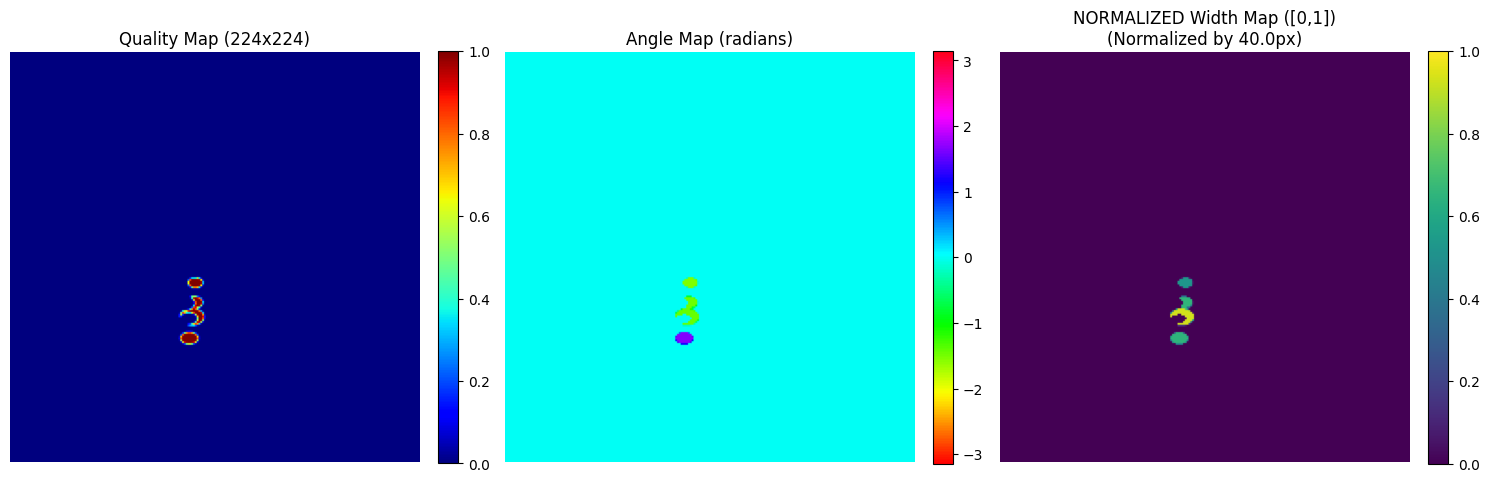

In [12]:
from PIL import Image, ImageDraw # Make sure ImageDraw is imported

def generate_ggcnn_maps_normalized_width(positive_grasps_points_list, negative_grasps_points_list, 
                                         original_image_shape, output_map_size):
    """
    Generates quality, angle, and NORMALIZED width maps for GG-CNN.
    Width map values will be normalized to [0,1] based on MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED.
    original_image_shape: tuple (height, width) of the original RGB/Depth image.
    output_map_size: tuple (height, width) for the final resized maps.
    """
    quality_map_orig = np.zeros(original_image_shape, dtype=np.float32)
    angle_map_orig = np.zeros(original_image_shape, dtype=np.float32)
    width_map_pixels_orig = np.zeros(original_image_shape, dtype=np.float32) # Store raw pixel widths first

    # Process positive grasps
    for grasp_points in positive_grasps_points_list:
        center_x, center_y, angle_rad, width_px = grasp_points_to_center_angle_width(grasp_points)
        
        radius_major = width_px / 2.0
        radius_minor = width_px / 4.0 
        
        mask_img_pil = Image.new('L', (original_image_shape[1], original_image_shape[0]), 0)
        draw = ImageDraw.Draw(mask_img_pil)
        x_start = center_x - radius_major
        y_start = center_y - radius_minor
        x_end = center_x + radius_major
        y_end = center_y + radius_minor
        draw.ellipse([x_start, y_start, x_end, y_end], fill=255)
        del draw

        grasp_mask = np.array(mask_img_pil, dtype=np.float32) / 255.0
        
        quality_map_orig = np.maximum(quality_map_orig, grasp_mask)
        angle_map_orig += grasp_mask * angle_rad
        width_map_pixels_orig += grasp_mask * width_px # Accumulate pixel widths

    # Process negative grasps (to subtract from quality map)
    if negative_grasps_points_list:
        negative_quality_mask_sum = np.zeros(original_image_shape, dtype=np.float32)
        for grasp_points in negative_grasps_points_list:
            center_x, center_y, _, width_px = grasp_points_to_center_angle_width(grasp_points)
            radius_major = width_px / 2.0
            radius_minor = width_px / 4.0
            mask_img_pil = Image.new('L', (original_image_shape[1], original_image_shape[0]), 0)
            draw = ImageDraw.Draw(mask_img_pil)
            x_start = center_x - radius_major; y_start = center_y - radius_minor
            x_end = center_x + radius_major; y_end = center_y + radius_minor
            draw.ellipse([x_start, y_start, x_end, y_end], fill=255)
            del draw
            neg_grasp_mask = np.array(mask_img_pil, dtype=np.float32) / 255.0
            negative_quality_mask_sum = np.maximum(negative_quality_mask_sum, neg_grasp_mask)

        quality_map_orig = quality_map_orig - negative_quality_mask_sum
        quality_map_orig = np.clip(quality_map_orig, 0.0, 1.0)

    # Clip to ensure values are not excessively large before normalization
    width_map_pixels_orig_clipped = np.clip(width_map_pixels_orig, 0, MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED)
    # Normalize to [0,1]
    width_map_normalized_orig = width_map_pixels_orig_clipped / MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED
    
    # Resize maps to the final output_map_size
    # Quality map:
    quality_map_pil = Image.fromarray((quality_map_orig * 255).astype(np.uint8), mode='L')
    quality_map_resized = quality_map_pil.resize((output_map_size[1], output_map_size[0]), Image.BILINEAR)
    final_quality_map = np.array(quality_map_resized, dtype=np.float32) / 255.0

    # Angle and NORMALIZED Width maps using cv2.resize for float values
    if cv2 is not None:
        final_angle_map = cv2.resize(angle_map_orig, (output_map_size[1], output_map_size[0]), interpolation=cv2.INTER_LINEAR)
        # Resize the NORMALIZED width map
        final_width_map_normalized = cv2.resize(width_map_normalized_orig, (output_map_size[1], output_map_size[0]), interpolation=cv2.INTER_LINEAR)
        # Clip normalized width map to be within [0,1] after resize (interpolation can push it slightly out)
        final_width_map_normalized = np.clip(final_width_map_normalized, 0.0, 1.0)
    else: 
        print("Warning: cv2 not available. Resizing for angle/width will be problematic.")
        final_angle_map = np.zeros(output_map_size, dtype=np.float32) # Placeholder
        final_width_map_normalized = np.zeros(output_map_size, dtype=np.float32) # Placeholder

    zero_quality_mask = (final_quality_map < 1e-3)
    final_angle_map[zero_quality_mask] = 0.0
    final_width_map_normalized[zero_quality_mask] = 0.0 # Zero out normalized width too
    
    return final_quality_map, final_angle_map, final_width_map_normalized # Return normalized width


# Test the updated generate_ggcnn_maps_normalized_width
# Ensure parsed_pos_grasps, parsed_neg_grasps, rgb_image_np, OUTPUT_IMG_SIZE are available from previous cells

print(f"\nTesting generate_ggcnn_maps_normalized_width (MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED = {MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED})")
if 'rgb_image_np' in locals() and rgb_image_np is not None:
    original_shape_test = rgb_image_np.shape[:2]
    
    # Use the NEW map generation function
    q_map_norm_test, ang_map_norm_test, w_map_norm_test = generate_ggcnn_maps_normalized_width(
        parsed_pos_grasps, parsed_neg_grasps, 
        original_shape_test, OUTPUT_IMG_SIZE
    )
    
    print(f"Generated Quality Map: Shape={q_map_norm_test.shape}, Min={q_map_norm_test.min():.2f}, Max={q_map_norm_test.max():.2f}")
    print(f"Generated Angle Map: Shape={ang_map_norm_test.shape}, Min={ang_map_norm_test.min():.2f}, Max={ang_map_norm_test.max():.2f}")
    print(f"Generated NORMALIZED Width Map: Shape={w_map_norm_test.shape}, Min={w_map_norm_test.min():.2f}, Max={w_map_norm_test.max():.2f} (Expected [0,1])")

    # Visualize the generated maps
    fig_maps_norm, axes_maps_norm = plt.subplots(1, 3, figsize=(15, 5))
    
    im0_norm = axes_maps_norm[0].imshow(q_map_norm_test, cmap='jet', vmin=0, vmax=1)
    axes_maps_norm[0].set_title(f"Quality Map ({OUTPUT_IMG_SIZE[0]}x{OUTPUT_IMG_SIZE[1]})")
    axes_maps_norm[0].axis('off')
    fig_maps_norm.colorbar(im0_norm, ax=axes_maps_norm[0], fraction=0.046, pad=0.04)

    im1_norm = axes_maps_norm[1].imshow(ang_map_norm_test, cmap='hsv', vmin=-np.pi, vmax=np.pi)
    axes_maps_norm[1].set_title("Angle Map (radians)")
    axes_maps_norm[1].axis('off')
    fig_maps_norm.colorbar(im1_norm, ax=axes_maps_norm[1], fraction=0.046, pad=0.04)

    # Width map is now NORMALIZED [0,1]
    im2_norm = axes_maps_norm[2].imshow(w_map_norm_test, cmap='viridis', vmin=0, vmax=1.0) # vmin/vmax for [0,1] range
    axes_maps_norm[2].set_title(f"NORMALIZED Width Map ([0,1])\n(Normalized by {MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED}px)")
    axes_maps_norm[2].axis('off')
    fig_maps_norm.colorbar(im2_norm, ax=axes_maps_norm[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
else:
    print("RGB image not loaded, cannot test updated map generation.")

## 3.3. Image Preprocessing

Preprocessed RGB-D input tensor shape: (4, 224, 224)
Input tensor dtype: float32
Input tensor Min: 0.00, Max: 1.00


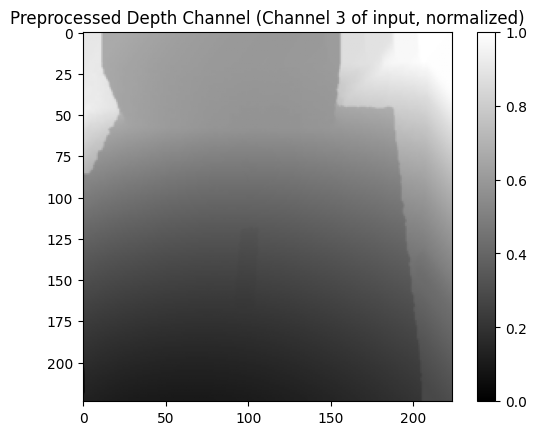

In [13]:
def preprocess_rgbd_input(rgb_img_pil, depth_img_pil, output_size_hw):
    """
    Preprocesses RGB and Depth PIL Images for model input.
    - Resizes both images to output_size_hw (height, width).
    - Normalizes RGB to [0,1].
    - Normalizes Depth (min-max scaling to [0,1] for the given image).
    - Stacks into a 4-channel NumPy array (H, W, C) then transposes to (C, H, W).
    Returns a NumPy array.
    """
    # Resize
    rgb_resized = rgb_img_pil.resize((output_size_hw[1], output_size_hw[0]), Image.BILINEAR)
    depth_resized = depth_img_pil.resize((output_size_hw[1], output_size_hw[0]), Image.BILINEAR) # Depth is float

    rgb_np = np.array(rgb_resized, dtype=np.float32) / 255.0 # H, W, C
    depth_np = np.array(depth_resized, dtype=np.float32)    # H, W (single channel)

    # Normalize depth (min-max for this specific image)
    if depth_np.max() > depth_np.min():
        depth_normalized_np = (depth_np - depth_np.min()) / (depth_np.max() - depth_np.min())
    else:
        depth_normalized_np = np.zeros_like(depth_np)
        
    depth_normalized_np = np.expand_dims(depth_normalized_np, axis=-1) # Add channel dim: H, W, 1

    # Stack RGB and Depth
    # rgb_np is (H, W, 3), depth_normalized_np is (H, W, 1)
    rgbd_np_hwc = np.concatenate((rgb_np, depth_normalized_np), axis=-1) # H, W, 4
    
    # Transpose to (C, H, W) for PyTorch
    rgbd_np_chw = rgbd_np_hwc.transpose((2, 0, 1)) # 4, H, W
    
    return rgbd_np_chw

# Test preprocess_rgbd_input
if 'rgb_image' in locals() and 'depth_image' in locals() and rgb_image and depth_image:
    # Reload PIL images as the previous rgb_image_np was just the array
    rgb_pil_for_test = Image.open(rgb_image_path)
    depth_pil_for_test = Image.open(depth_image_path)

    input_tensor_np = preprocess_rgbd_input(rgb_pil_for_test, depth_pil_for_test, OUTPUT_IMG_SIZE)
    print(f"Preprocessed RGB-D input tensor shape: {input_tensor_np.shape}") # Expected: (4, 224, 224)
    print(f"Input tensor dtype: {input_tensor_np.dtype}")
    print(f"Input tensor Min: {input_tensor_np.min():.2f}, Max: {input_tensor_np.max():.2f}")

    # Visualize a channel (e.g., the depth channel) from the preprocessed input
    plt.imshow(input_tensor_np[3], cmap='gray') # Display the preprocessed depth channel
    plt.title(f"Preprocessed Depth Channel (Channel 3 of input, normalized)")
    plt.colorbar()
    plt.show()
else:
    print("Sample PIL images (rgb_image, depth_image) not available in current scope for testing.")

## 3.4. Caching Preprocessed Data


Re-caching all preprocessed maps with NORMALIZED width...
Starting preprocessing and caching for 885 scenes...
Using map generation function: generate_ggcnn_maps_normalized_width
Output maps will be 224x224.


Preprocessing & Caching Maps:   0%|          | 0/885 [00:00<?, ?it/s]

Preprocessing and caching complete.
Scenes processed/regenerated: 885
Scenes skipped (already cached): 0

Verifying a sample re-cached width map...


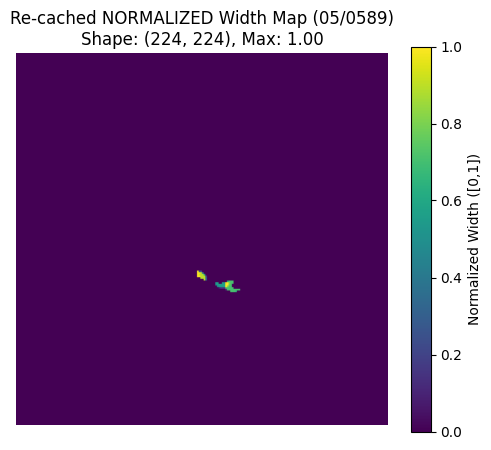

  Min/Max of re-cached width map: 0.00 / 1.00


In [14]:
def cache_all_preprocessed_maps_flexible(all_scene_ids_list, base_data_path, 
                                         preprocessed_output_dir, target_map_size_hw,
                                         map_generation_function, # Pass the specific map generator
                                         force_regenerate=False):
    """
    Generates and caches the Q, Angle, and Width (potentially normalized) maps for all scenes.
    """
    print(f"Starting preprocessing and caching for {len(all_scene_ids_list)} scenes...")
    print(f"Using map generation function: {map_generation_function.__name__}")
    print(f"Output maps will be {target_map_size_hw[0]}x{target_map_size_hw[1]}.")
    
    scenes_processed = 0
    scenes_skipped = 0

    for scene_info in tqdm(all_scene_ids_list, desc="Preprocessing & Caching Maps"):
        folder = scene_info['folder']
        scene_id = scene_info['scene_id']
        
        scene_output_folder = preprocessed_output_dir / folder
        os.makedirs(scene_output_folder, exist_ok=True)
        
        q_map_path = scene_output_folder / f"pcd{scene_id}_quality.npy"
        ang_map_path = scene_output_folder / f"pcd{scene_id}_angle.npy"
        w_map_path = scene_output_folder / f"pcd{scene_id}_width.npy" # Will store normalized width
        
        if not force_regenerate and \
           q_map_path.exists() and ang_map_path.exists() and w_map_path.exists():
            scenes_skipped += 1
            continue
            
        pos_grasps_pts = parse_grasp_rectangles(base_data_path / folder / f"pcd{scene_id}cpos.txt")
        neg_grasps_pts = parse_grasp_rectangles(base_data_path / folder / f"pcd{scene_id}cneg.txt")
        
        rgb_path = base_data_path / folder / f"pcd{scene_id}r.png"
        img_for_shape_pil = None
        if rgb_path.exists():
            img_for_shape_pil = Image.open(rgb_path)
        else:
            depth_path = base_data_path / folder / f"pcd{scene_id}d.tiff"
            if depth_path.exists():
                img_for_shape_pil = Image.open(depth_path)
            else:
                print(f"ERROR: No image found for {folder}/{scene_id} to get shape. Skipping.")
                continue
        
        original_shape_hw = (img_for_shape_pil.height, img_for_shape_pil.width)
        img_for_shape_pil.close()
        
        # Use the passed map_generation_function
        # It's expected to return: quality_map, angle_map, width_map (which is now normalized)
        q_map, ang_map, width_map_output = map_generation_function(
            pos_grasps_pts, neg_grasps_pts,
            original_shape_hw, target_map_size_hw
        )
        
        np.save(q_map_path, q_map)
        np.save(ang_map_path, ang_map)
        np.save(w_map_path, width_map_output) # Save the (potentially normalized) width map
        scenes_processed += 1
        
    print("Preprocessing and caching complete.")
    print(f"Scenes processed/regenerated: {scenes_processed}")
    print(f"Scenes skipped (already cached): {scenes_skipped}")

# Run the caching process with the NEW map generation function
# Ensure all_scene_identifiers, DATA_PATH, PREPROCESSED_DATA_DIR, OUTPUT_IMG_SIZE are defined.
# CRITICAL: Set force_regenerate=True to overwrite old maps with normalized width maps.
print("\nRe-caching all preprocessed maps with NORMALIZED width...")
cache_all_preprocessed_maps_flexible(
    all_scene_ids_list=all_scene_identifiers, 
    base_data_path=DATA_PATH, 
    preprocessed_output_dir=PREPROCESSED_DATA_DIR, 
    target_map_size_hw=OUTPUT_IMG_SIZE,
    map_generation_function=generate_ggcnn_maps_normalized_width,
    force_regenerate=True  # <<< FORCE REGENERATION
)

# After this, verify one of the newly saved _width.npy files to see if its values are [0,1]
print("\nVerifying a sample re-cached width map...")
sample_recached_w_map_path = PREPROCESSED_DATA_DIR / '05' / "pcd0589_width.npy" # Same sample as before
if sample_recached_w_map_path.exists():
    recached_w_map_sample = np.load(sample_recached_w_map_path)
    plt.figure(figsize=(6,5))
    plt.imshow(recached_w_map_sample, cmap='viridis', vmin=0, vmax=1.0) 
    plt.title(f"Re-cached NORMALIZED Width Map (05/0589)\nShape: {recached_w_map_sample.shape}, Max: {recached_w_map_sample.max():.2f}")
    plt.colorbar(label="Normalized Width ([0,1])")
    plt.axis('off')
    plt.show()
    print(f"  Min/Max of re-cached width map: {recached_w_map_sample.min():.2f} / {recached_w_map_sample.max():.2f}")
else:
    print(f"Sample re-cached width map not found: {sample_recached_w_map_path}")

## 3.5. PyTorch Datasets & DataLoaders

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np 
from pathlib import Path
import json

class CornellGraspDataset(Dataset):
    def __init__(self, scene_ids_list, base_data_path, preprocessed_data_dir, 
                 output_img_size_hw, augmentations=None): # augmentations not used yet
        self.scene_ids_list = scene_ids_list
        self.base_data_path = base_data_path
        self.preprocessed_data_dir = preprocessed_data_dir
        self.output_img_size_hw = output_img_size_hw
        self.augmentations = augmentations # Placeholder for now

    def __len__(self):
        return len(self.scene_ids_list)

    def __getitem__(self, idx):
        scene_info = self.scene_ids_list[idx] # dict: {'folder': ..., 'scene_id': ...}
        folder = scene_info['folder']
        scene_id_str = scene_info['scene_id']

        # Load original RGB and Depth PIL images
        rgb_path = self.base_data_path / folder / f"pcd{scene_id_str}r.png"
        depth_path = self.base_data_path / folder / f"pcd{scene_id_str}d.tiff"

        try:
            rgb_pil = Image.open(rgb_path).convert('RGB') # Ensure 3 channels for RGB
            depth_pil = Image.open(depth_path) # Depth is usually single channel float
        except FileNotFoundError:
            print(f"Error: Image file not found for scene {folder}/{scene_id_str} at index {idx}.")
            # For robustness, especially if scene_ids_list could be stale:
            raise FileNotFoundError(f"FATAL: Image file not found for {folder}/{scene_id_str}. Please check dataset integrity and scene ID list generation.")

        # Preprocess RGB-D input
        # preprocess_rgbd_input returns a NumPy array (C, H, W)
        input_rgbd_np = preprocess_rgbd_input(rgb_pil, depth_pil, self.output_img_size_hw)
        
        # Augmentations would go here if active
        
        # Load pre-cached .npy label maps
        scene_preprocessed_folder = self.preprocessed_data_dir / folder
        q_map_path = scene_preprocessed_folder / f"pcd{scene_id_str}_quality.npy"
        ang_map_path = scene_preprocessed_folder / f"pcd{scene_id_str}_angle.npy"
        w_map_path = scene_preprocessed_folder / f"pcd{scene_id_str}_width.npy"

        try:
            q_map_np = np.load(q_map_path)
            ang_map_np = np.load(ang_map_path)
            w_map_np = np.load(w_map_path)
        except FileNotFoundError:
            print(f"Error: Preprocessed map not found for scene {folder}/{scene_id_str} at index {idx}.")
            raise FileNotFoundError(f"FATAL: Preprocessed map not found for {folder}/{scene_id_str}. Ensure map caching script ran successfully.")

        # Convert all NumPy arrays to PyTorch tensors
        input_tensor = torch.from_numpy(input_rgbd_np).float()
        quality_tensor = torch.from_numpy(q_map_np).float() 
        angle_tensor = torch.from_numpy(ang_map_np).float()
        width_tensor = torch.from_numpy(w_map_np).float()
        
        # Return scene_info as the 5th item
        return input_tensor, quality_tensor, angle_tensor, width_tensor, scene_info

# Load dataset splits (train_ids, val_ids, test_ids)
# This part assumes the JSON file exists and contains the IDs.
# Global PREPROCESSED_DATA_DIR should be defined.
splits_file_path = PREPROCESSED_DATA_DIR / "dataset_splits.json"
if not splits_file_path.exists():
    print(f"FATAL ERROR: Dataset splits file '{splits_file_path}' not found!")
    print("Please ensure the dataset splitting cell (usually in section 3.1) has been run successfully.")
    # Depending on notebook flow, you might raise an error here or try to re-run splitting.
    # For now, assume it should exist.
    raise FileNotFoundError(f"Dataset splits file missing: {splits_file_path}")
else:
    print(f"Loading dataset splits from: {splits_file_path}")
    with open(splits_file_path, 'r') as f:
        loaded_splits = json.load(f)
        train_ids = loaded_splits['train_ids']
        val_ids = loaded_splits['val_ids']
        test_ids = loaded_splits['test_ids']
    print(f"  Loaded {len(train_ids)} train, {len(val_ids)} val, and {len(test_ids)} test IDs.")


# Create Dataset instances
# Global DATA_PATH and OUTPUT_IMG_SIZE should be defined.
print("\nCreating Dataset instances...")
train_dataset = CornellGraspDataset(train_ids, DATA_PATH, PREPROCESSED_DATA_DIR, OUTPUT_IMG_SIZE)
val_dataset = CornellGraspDataset(val_ids, DATA_PATH, PREPROCESSED_DATA_DIR, OUTPUT_IMG_SIZE)
test_dataset = CornellGraspDataset(test_ids, DATA_PATH, PREPROCESSED_DATA_DIR, OUTPUT_IMG_SIZE)

print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")
print(f"  Test dataset size: {len(test_dataset)}")

# Create DataLoader instances
# Global BATCH_SIZE, NUM_WORKERS, DEVICE should be defined.
print("\nCreating DataLoader instances...")
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=NUM_WORKERS,
                          pin_memory=True if DEVICE.type == 'cuda' else False)

val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        pin_memory=True if DEVICE.type == 'cuda' else False)

test_loader = DataLoader(test_dataset, # This will be our primary test loader now
                         batch_size=BATCH_SIZE, 
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         pin_memory=True if DEVICE.type == 'cuda' else False)

print(f"  DataLoaders created with Batch Size: {BATCH_SIZE} and Num Workers: {NUM_WORKERS}")

Loading dataset splits from: preprocessed_ggcnn/dataset_splits.json
  Loaded 638 train, 159 val, and 88 test IDs.

Creating Dataset instances...
  Train dataset size: 638
  Validation dataset size: 159
  Test dataset size: 88

Creating DataLoader instances...
  DataLoaders created with Batch Size: 16 and Num Workers: 0


# 4. Model Implementations

## 4.1. Model 1: Baseline GG-CNN.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class GGCNN_Baseline_BN_SigmoidWidth(nn.Module): # New name for clarity
    def __init__(self, input_channels=4, output_channels=4): # output_channels is fixed at 4
        super(GGCNN_Baseline_BN_SigmoidWidth, self).__init__()

        # Encoder (with BatchNorm2d) - Same as GGCNN_Baseline_BN_ActivationChoice
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True)
        )

        # Decoder (with BatchNorm2d) - Same as GGCNN_Baseline_BN_ActivationChoice
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True)
        )
        
        # Output head for 4 maps (quality_logit, cos_angle, sin_angle, width_logit_for_sigmoid)
        self.output_head = nn.Conv2d(32, 4, kernel_size=1, stride=1, padding=0)
        
        # Sigmoid activation for width will be applied in forward pass

    def forward(self, x):
        # Encoder and Decoder parts are the same
        x1_feat = self.conv1(x)
        x_pool1 = self.pool1(x1_feat)
        x2_feat = self.conv2(x_pool1)
        x_pool2 = self.pool2(x2_feat)
        bottleneck = self.conv3(x_pool2)
        x_up2 = self.upconv2(bottleneck)
        x_skip2 = torch.cat([x_up2, x2_feat], dim=1)
        x_dec2 = self.dec_conv2(x_skip2)
        x_up1 = self.upconv1(x_dec2)
        x_skip1 = torch.cat([x_up1, x1_feat], dim=1)
        x_dec1 = self.dec_conv1(x_skip1)
        
        output_maps_raw = self.output_head(x_dec1) # (N, 4, H, W)
        
        pred_quality_logit = output_maps_raw[:, 0, :, :]
        pred_cos_angle = output_maps_raw[:, 1, :, :]
        pred_sin_angle = output_maps_raw[:, 2, :, :]
        
        # Width channel now outputs a logit, apply sigmoid for normalized width [0,1]
        pred_width_logit_normalized = output_maps_raw[:, 3, :, :]
        pred_width_normalized = torch.sigmoid(pred_width_logit_normalized) 
        
        # Model returns the normalized width prediction
        return pred_quality_logit, pred_cos_angle, pred_sin_angle, pred_width_normalized

## 4.2. Model 2: Improved GG-CNN (Placeholder until update)

**Improvements**:
- Deeper/Wider Backbone: We'll increase the number of channels in the convolutional layers.
- Attention Mechanism: We'll incorporate Squeeze-and-Excitation (SE) blocks.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

# SEBlock class definition (if not already defined in a previous cell, or re-define for clarity)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_ratio, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class GGCNN_Improved(nn.Module):
    def __init__(self, input_channels=4, output_channels=4, reduction_ratio=16):
        super(GGCNN_Improved, self).__init__()

        # Encoder (Wider, with BatchNorm2d and SE Blocks)
        # Block 1: input_channels -> 64 channels
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )
        self.se1 = SEBlock(64, reduction_ratio)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # H -> H/2

        # Block 2: 64 -> 128 channels
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True)
        )
        self.se2 = SEBlock(128, reduction_ratio)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # H/2 -> H/4
        
        # Block 3 (Bottleneck): 128 -> 256 channels
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True)
        )
        self.se3 = SEBlock(256, reduction_ratio)
        # No pooling after enc_conv3

        # Decoder (with BatchNorm2d and SE Blocks)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # H/4 -> H/2
        # Decoder Block 2: (128 from upconv + 128 from se2_out) -> 128 channels
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # Input is 128+128=256
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True)
        )
        self.dec_se2 = SEBlock(128, reduction_ratio)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # H/2 -> H
        # Decoder Block 1: (64 from upconv + 64 from se1_out) -> 64 channels
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2), # Input is 64+64=128
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )
        self.dec_se1 = SEBlock(64, reduction_ratio)

        # Output head
        self.output_head = nn.Conv2d(64, output_channels, kernel_size=1, stride=1, padding=0)
        # Sigmoid for normalized width will be applied in forward

    def forward(self, x):
        # Encoder
        x1 = self.enc_conv1(x)
        se1_out = self.se1(x1)
        p1 = self.pool1(se1_out)
        
        x2 = self.enc_conv2(p1)
        se2_out = self.se2(x2)
        p2 = self.pool2(se2_out)
        
        x3 = self.enc_conv3(p2)
        bottleneck = self.se3(x3)

        # Decoder
        u2 = self.upconv2(bottleneck)
        cat2 = torch.cat([u2, se2_out], dim=1) # Skip connection from SE block output
        d2 = self.dec_conv2(cat2)
        d2_se = self.dec_se2(d2)
        
        u1 = self.upconv1(d2_se)
        cat1 = torch.cat([u1, se1_out], dim=1) # Skip connection from SE block output
        d1 = self.dec_conv1(cat1)
        d1_se = self.dec_se1(d1)
        
        output_maps_raw = self.output_head(d1_se)
        
        pred_quality_logit = output_maps_raw[:, 0, :, :]
        pred_cos_angle = output_maps_raw[:, 1, :, :]
        pred_sin_angle = output_maps_raw[:, 2, :, :]
        
        pred_width_logit_normalized = output_maps_raw[:, 3, :, :]
        pred_width_normalized = torch.sigmoid(pred_width_logit_normalized) 
        
        return pred_quality_logit, pred_cos_angle, pred_sin_angle, pred_width_normalized

## 4.3. Common Components

In [18]:
def compute_ggcnn_loss_updated_width_weight(
                       pred_quality_logit, pred_cos_angle, pred_sin_angle, pred_width,
                       true_quality, true_angle_rad, true_width, device):
    """
    Computes the composite loss for GG-CNN style models with updated width weight.
    All inputs (preds and trues) are expected to be on the correct device.
    pred_*: model outputs (N, H, W)
    true_*: ground truth maps (N, H, W)
    true_angle_rad: ground truth angle in radians.
    """
    
    # Ensure targets are on the same device as predictions if not already
    true_quality = true_quality.to(device)
    true_angle_rad = true_angle_rad.to(device)
    true_width = true_width.to(device)

    # Make model predictions contiguous, as slicing can make them non-contiguous
    pred_quality_logit = pred_quality_logit.contiguous()
    pred_cos_angle = pred_cos_angle.contiguous()
    pred_sin_angle = pred_sin_angle.contiguous()
    pred_width = pred_width.contiguous() # This will be the output after ReLU/Softplus etc.

    # Quality Loss (BCEWithLogitsLoss)
    bce_loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    quality_loss = bce_loss_fn(pred_quality_logit, true_quality)

    # Angle Loss (SmoothL1Loss on cos and sin components)
    true_cos_angle = torch.cos(true_angle_rad)
    true_sin_angle = torch.sin(true_angle_rad)
    
    smooth_l1_loss_fn = nn.SmoothL1Loss(reduction='mean') # Can reuse for width
    cos_angle_loss = smooth_l1_loss_fn(pred_cos_angle, true_cos_angle)
    sin_angle_loss = smooth_l1_loss_fn(pred_sin_angle, true_sin_angle)
    angle_loss = cos_angle_loss + sin_angle_loss

    # Width Loss (SmoothL1Loss)
    # pred_width is now output after chosen activation (e.g., ReLU)
    width_loss = smooth_l1_loss_fn(pred_width, true_width)
    
    # Combine losses with weights
    w_quality = 1.0
    w_angle = 1.0   # Weight for the sum of cos and sin losses
    w_width = 10.0 

    total_loss = (w_quality * quality_loss) + \
                 (w_angle * angle_loss) + \
                 (w_width * width_loss)
                 
    return total_loss, quality_loss, angle_loss, width_loss

# 5. Methods

## 5.1. Training Procedure:

In [19]:
import torch.optim as optim
import time # To measure epoch time

def train_epoch(model, data_loader, loss_fn, optimizer, device, epoch_num=-1):
    model.train()
    total_loss = 0.0
    total_q_loss = 0.0
    total_ang_loss = 0.0
    total_w_loss = 0.0
    
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch_num} Train", leave=False)
    
    for batch_idx, (input_tensor, true_q, true_ang_rad, true_w, _scene_info_batch) in enumerate(progress_bar):
        input_tensor = input_tensor.to(device)
        optimizer.zero_grad()
        
        pred_q_logit, pred_cos_a, pred_sin_a, pred_w = model(input_tensor)
        
        loss, q_loss, ang_loss, w_loss = loss_fn(
            pred_q_logit, pred_cos_a, pred_sin_a, pred_w,
            true_q, true_ang_rad, true_w,
            device
        )
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_q_loss += q_loss.item()
        total_ang_loss += ang_loss.item()
        total_w_loss += w_loss.item()

        if batch_idx > 0 and batch_idx % 10 == 0: # Update every 10 batches, skip first to avoid div by zero if batch 0 is small
             progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'AvgLoss': f'{total_loss / (batch_idx + 1):.4f}' # total_loss is sum over items
            })
            
    avg_loss = total_loss / len(data_loader) # len(data_loader) is number of batches
    avg_q_loss = total_q_loss / len(data_loader)
    avg_ang_loss = total_ang_loss / len(data_loader)
    avg_w_loss = total_w_loss / len(data_loader)
    
    progress_bar.close()
    return avg_loss, avg_q_loss, avg_ang_loss, avg_w_loss


def validate_epoch(model, data_loader, loss_fn, device, epoch_num=-1):
    model.eval()
    total_loss = 0.0
    total_q_loss = 0.0
    total_ang_loss = 0.0
    total_w_loss = 0.0
    
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch_num} Val  ", leave=False)
    
    with torch.no_grad():
        for batch_idx, (input_tensor, true_q, true_ang_rad, true_w, _scene_info_batch) in enumerate(progress_bar):
            input_tensor = input_tensor.to(device)
            pred_q_logit, pred_cos_a, pred_sin_a, pred_w = model(input_tensor)
            
            loss, q_loss, ang_loss, w_loss = loss_fn(
                pred_q_logit, pred_cos_a, pred_sin_a, pred_w,
                true_q, true_ang_rad, true_w,
                device
            )
            
            total_loss += loss.item()
            total_q_loss += q_loss.item()
            total_ang_loss += ang_loss.item()
            total_w_loss += w_loss.item()

            if batch_idx > 0 and batch_idx % 10 == 0:
                 progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'AvgLoss': f'{total_loss / (batch_idx + 1):.4f}'
                })

    avg_loss = total_loss / len(data_loader)
    avg_q_loss = total_q_loss / len(data_loader)
    avg_ang_loss = total_ang_loss / len(data_loader)
    avg_w_loss = total_w_loss / len(data_loader)
    
    progress_bar.close()
    return avg_loss, avg_q_loss, avg_ang_loss, avg_w_loss

# Main training loop function
def training_loop(model, model_name, train_loader, val_loader, loss_fn, 
                  learning_rate, epochs, device, patience=5):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    history = {
        'train_loss': [], 'train_q_loss': [], 'train_ang_loss': [], 'train_w_loss': [],
        'val_loss': [], 'val_q_loss': [], 'val_ang_loss': [], 'val_w_loss': []
    }
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    model_save_path = PREPROCESSED_DATA_DIR.parent / f"{model_name}_best.pth" # Save in project root

    print(f"\nStarting training for {model_name}...")
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        train_loss, tr_q, tr_ang, tr_w = train_epoch(model, train_loader, loss_fn, optimizer, device, epoch)
        val_loss, v_q, v_ang, v_w = validate_epoch(model, val_loader, loss_fn, device, epoch)
        
        epoch_duration = time.time() - start_time
        
        print(f"Epoch {epoch}/{epochs} [{epoch_duration:.2f}s]:")
        print(f"  Train Loss: {train_loss:.4f} (Q:{tr_q:.4f}, Ang:{tr_ang:.4f}, W:{tr_w:.4f})")
        print(f"  Val   Loss: {val_loss:.4f} (Q:{v_q:.4f}, Ang:{v_ang:.4f}, W:{v_w:.4f})")
        
        history['train_loss'].append(train_loss)
        history['train_q_loss'].append(tr_q)
        history['train_ang_loss'].append(tr_ang)
        history['train_w_loss'].append(tr_w)
        
        history['val_loss'].append(val_loss)
        history['val_q_loss'].append(v_q)
        history['val_ang_loss'].append(v_ang)
        history['val_w_loss'].append(v_w)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"    => Best model saved to {model_save_path} (Val Loss: {best_val_loss:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"    Val loss did not improve. Count: {epochs_no_improve}/{patience}")
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break
            
    print(f"Training finished for {model_name}.")
    print(f"Best validation loss: {best_val_loss:.4f}. Model saved to {model_save_path}")
    return history, model_save_path


# Placeholder for plotting loss curves
def plot_loss_curves(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Total Loss')
    plt.plot(history['val_loss'], label='Val Total Loss')
    plt.title(f'{model_name} - Total Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 5.2. Evaluation Metrics

In [20]:
def oriented_rectangle_to_polygon_corners(cx, cy, grasp_angle_rad, grasp_width, grasp_height):
    """
    Converts center, grasp_angle_rad (orientation of width), grasp_width, and grasp_height (gripper depth)
    of an oriented rectangle to its 4 corner points.
    grasp_angle_rad is the orientation of the side corresponding to grasp_width.
    grasp_height is the dimension perpendicular to grasp_width.
    """
    # Half dimensions
    w_half = grasp_width / 2.0
    h_half = grasp_height / 2.0

    # Unit vector along the grasp_width direction
    cos_a = math.cos(grasp_angle_rad)
    sin_a = math.sin(grasp_angle_rad)

    # Unit vector along the grasp_height direction (perpendicular to width)
    cos_h_a = -sin_a 
    sin_h_a = cos_a
    
    # Vector for width direction
    w_dx_vec = w_half * cos_a
    w_dy_vec = w_half * sin_a
    # Vector for height direction
    h_dx_vec = h_half * cos_h_a
    h_dy_vec = h_half * sin_h_a
    
    x0 = cx - w_dx_vec + h_dx_vec
    y0 = cy - w_dy_vec + h_dy_vec
    
    x1 = cx + w_dx_vec + h_dx_vec
    y1 = cy + w_dy_vec + h_dy_vec
    
    x2 = cx + w_dx_vec - h_dx_vec
    y2 = cy + w_dy_vec - h_dy_vec
    
    x3 = cx - w_dx_vec - h_dx_vec
    y3 = cy - w_dy_vec - h_dy_vec
    
    return [[x0, y0], [x1, y1], [x2, y2], [x3, y3]]

In [21]:
def grasp_maps_to_best_rectangle(quality_map_logit, cos_angle_map, sin_angle_map, width_map, 
                                 quality_thresh=0.25, grasp_height_px=20.0):
    """
    Converts model output maps to the best predicted grasp rectangle (4 corner points).
    quality_map_logit: Raw logit output for quality (N, H, W) or (H, W) - apply sigmoid internally.
    cos_angle_map, sin_angle_map, width_map: Raw model outputs (N, H, W) or (H, W).
    quality_thresh: Minimum sigmoid quality to consider a grasp.
    grasp_height_px: Assumed fixed gripper depth/height for the rectangle.
    """
    if isinstance(quality_map_logit, torch.Tensor):
        # Assuming maps are on CPU for numpy operations, or move them
        quality_map_logit = quality_map_logit.cpu().numpy()
        cos_angle_map = cos_angle_map.cpu().numpy()
        sin_angle_map = sin_angle_map.cpu().numpy()
        width_map = width_map.cpu().numpy()

    # If batch dimension exists (N,H,W), take the first sample (N=0)
    if quality_map_logit.ndim == 3:
        quality_map_logit = quality_map_logit[0]
        cos_angle_map = cos_angle_map[0]
        sin_angle_map = sin_angle_map[0]
        width_map = width_map[0]
        
    # Apply sigmoid to quality logits
    quality_map_sigmoid = 1 / (1 + np.exp(-quality_map_logit)) # Sigmoid function

    # Filter by quality threshold
    valid_quality_mask = quality_map_sigmoid > quality_thresh
    
    if not np.any(valid_quality_mask):
        return None # No grasp found above threshold

    # Find the pixel with the highest quality within the valid mask
    temp_quality_map = quality_map_sigmoid * valid_quality_mask
    max_quality_idx_flat = np.argmax(temp_quality_map)
    # Convert flat index to 2D (row, col) which is (y, x)
    best_y, best_x = np.unravel_index(max_quality_idx_flat, quality_map_sigmoid.shape)
    
    # Get grasp parameters at this best (y, x) location
    pred_angle_rad = math.atan2(sin_angle_map[best_y, best_x], cos_angle_map[best_y, best_x])
    pred_width_px = width_map[best_y, best_x]
    
    # Ensure width is positive (model might predict small negative due to regression)
    if pred_width_px < 0:
        pred_width_px = 1.0 # Set to a minimum small positive width

    # Convert to 4 corner points
    # best_x, best_y are pixel indices. They represent the center of the grasp.
    predicted_grasp_points = oriented_rectangle_to_polygon_corners(
        cx=float(best_x), 
        cy=float(best_y), 
        grasp_angle_rad=float(pred_angle_rad), 
        grasp_width=float(pred_width_px), 
        grasp_height=float(grasp_height_px) # Using the fixed grasp_height_px
    )
    
    return predicted_grasp_points, quality_map_sigmoid[best_y, best_x]

In [22]:
# Global constant for un-normalization (should match value used during map generation)
if 'MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED' not in locals():
    MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED = 100.0 # Default if not set, ensure consistency
    print(f"Warning: MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED not found, using default {MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED}")


def grasp_maps_to_best_rectangle_UNNORM(
        quality_map_logit, cos_angle_map, sin_angle_map, width_map_normalized, # width_map is now normalized
        quality_thresh=0.25, 
        grasp_height_px=20.0,
        max_pixel_width_for_unnorm=MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED): # For un-normalizing
    """
    Converts model output maps (with NORMALIZED width map) to the best predicted grasp rectangle.
    Un-normalizes the predicted width before generating corners.
    """
    # Convert tensors to numpy and handle batch dimension if present
    if isinstance(quality_map_logit, torch.Tensor):
        quality_map_logit = quality_map_logit.detach().cpu().numpy()
        cos_angle_map = cos_angle_map.detach().cpu().numpy()
        sin_angle_map = sin_angle_map.detach().cpu().numpy()
        width_map_normalized = width_map_normalized.detach().cpu().numpy()

    if quality_map_logit.ndim == 3: # (N, H, W) -> (H, W)
        quality_map_logit = quality_map_logit[0]
        cos_angle_map = cos_angle_map[0]
        sin_angle_map = sin_angle_map[0]
        width_map_normalized = width_map_normalized[0]
        
    quality_map_sigmoid = 1 / (1 + np.exp(-quality_map_logit))
    valid_quality_mask = quality_map_sigmoid > quality_thresh
    
    if not np.any(valid_quality_mask):
        return None 

    temp_quality_map = quality_map_sigmoid * valid_quality_mask
    max_quality_idx_flat = np.argmax(temp_quality_map)
    best_y, best_x = np.unravel_index(max_quality_idx_flat, quality_map_sigmoid.shape)
    
    pred_angle_rad = math.atan2(sin_angle_map[best_y, best_x], cos_angle_map[best_y, best_x])
    
    # ** UN-NORMALIZE predicted width **
    pred_width_normalized_at_peak = width_map_normalized[best_y, best_x]
    pred_width_pixels_at_peak = pred_width_normalized_at_peak * max_pixel_width_for_unnorm
    
    if pred_width_pixels_at_peak < 1.0: # Ensure a minimum physical width
        pred_width_pixels_at_peak = 1.0
    
    # Return all key parameters from the peak, including UN-NORMALIZED width
    # This makes it easier for downstream evaluation functions.
    peak_params = {
        'cx': float(best_x),
        'cy': float(best_y),
        'angle_rad': float(pred_angle_rad),
        'width_pixels': float(pred_width_pixels_at_peak), # Un-normalized
        'height_pixels': float(grasp_height_px), # The fixed height
        'quality_score': float(quality_map_sigmoid[best_y, best_x])
    }

    predicted_grasp_points = oriented_rectangle_to_polygon_corners(
        cx=peak_params['cx'], 
        cy=peak_params['cy'], 
        grasp_angle_rad=peak_params['angle_rad'], 
        grasp_width=peak_params['width_pixels'], # Use un-normalized width
        grasp_height=peak_params['height_pixels']
    )
    
    return predicted_grasp_points, peak_params # Return points and all peak parameters

In [23]:
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.validation import make_valid # To handle potentially invalid polygons

def calculate_iou(poly1_points, poly2_points):
    """
    Calculates Intersection over Union (IoU) for two polygons.
    poly1_points, poly2_points: List of [x,y] Ccorner points for each polygon.
    Returns IoU score (float).
    """

    if not poly1_points or not poly2_points or len(poly1_points) < 3 or len(poly2_points) < 3:
        return 0.0 # Not valid polygons

    try:
        polygon1 = ShapelyPolygon(poly1_points)
        polygon2 = ShapelyPolygon(poly2_points)

        # Sometimes polygons can be invalid (e.g. self-intersecting if points are weird)
        # make_valid can try to fix them.
        if not polygon1.is_valid:
            polygon1 = make_valid(polygon1)
            if not polygon1.is_valid: # Still not valid
                 print(f"Warning: poly1 remains invalid after make_valid. Points: {poly1_points}")
                 return 0.0
        if not polygon2.is_valid:
            polygon2 = make_valid(polygon2)
            if not polygon2.is_valid:
                 print(f"Warning: poly2 remains invalid after make_valid. Points: {poly2_points}")
                 return 0.0

        intersection_area = polygon1.intersection(polygon2).area
        union_area = polygon1.union(polygon2).area # Alternatively: polygon1.area + polygon2.area - intersection_area
        
        if union_area == 0:
            return 0.0 # Avoid division by zero; if union is 0, intersection must also be 0
            
        iou = intersection_area / union_area
        return iou
    except Exception as e:
        # This can happen with very degenerate polygons even with make_valid
        print(f"Error during IoU calculation with Shapely: {e}")
        print(f"  Poly1 points: {poly1_points}")
        print(f"  Poly2 points: {poly2_points}")
        return 0.0

In [24]:
def calculate_angle_difference_rad(angle1_rad, angle2_rad):
    """
    Calculates the smallest difference between two angles in radians.
    Result is in the range [-pi, pi].
    """
    # Normalize angles to be within a consistent 2*pi range, e.g. [0, 2*pi) or (-pi, pi]
    # Easiest way to get the difference is (a1 - a2), then normalize that difference.
    diff = angle1_rad - angle2_rad
    
    # Normalize the difference to the range [-pi, pi]
    # (diff + pi) % (2 * pi) - pi
    # This maps diff to [0, 2*pi) first, then shifts by -pi to get [-pi, pi)
    normalized_diff = (diff + math.pi) % (2 * math.pi) - math.pi
    
    # A common alternative, ensuring the result is always the shortest path:
    # diff = angle1_rad - angle2_rad
    # while diff > math.pi:
    #     diff -= 2 * math.pi
    # while diff < -math.pi:
    #     diff += 2 * math.pi
    # return diff
    # The modulo arithmetic above is generally more efficient.

    return normalized_diff

In [25]:
def calculate_angle_difference_rad_symmetric(angle1_rad, angle2_rad):
    """
    Calculates the smallest difference between two angles in radians,
    considering 180-degree (pi radians) symmetry for grasping.
    Result is the smallest absolute difference in [0, pi/2] if angles are perfectly aligned or flipped.
    More generally, it finds the difference to the closest alignment (either angle2 or angle2 + pi).
    The final output will be the signed difference to the closest alignment, in [-pi/2, pi/2] if logic is perfect,
    but we usually care about its absolute value.
    Let's return the signed shortest diff to one of the two symmetric orientations of angle2.
    """
    # Difference with angle2 directly
    diff1 = (angle1_rad - angle2_rad + math.pi) % (2 * math.pi) - math.pi

    # Difference with angle2 flipped by 180 degrees (pi radians)
    angle2_flipped = angle2_rad + math.pi
    diff2 = (angle1_rad - angle2_flipped + math.pi) % (2 * math.pi) - math.pi
    
    # Return the one with the smaller absolute value
    if abs(diff1) < abs(diff2):
        return diff1
    else:
        return diff2

## 5.3 Evaluation and Visualization Helper Functions

In [26]:
def evaluate_model_on_dataset(model, data_loader, device, loss_fn_for_stats_only,
                              iou_threshold=0.25, angle_diff_threshold_deg=30.0,
                              fixed_grasp_height_for_pred_px=20.0):
    """
    Evaluates the model on a given dataset (e.g., validation or test).
    Calculates average loss components and grasp success rate.
    loss_fn_for_stats_only: The same loss function used in training, just to report comparable loss values.
    """
    model.eval() # Set model to evaluation mode
    
    total_loss_val = 0.0
    total_q_loss_val = 0.0
    total_ang_loss_val = 0.0
    total_w_loss_val = 0.0
    
    successful_grasps = 0
    total_images_evaluated = 0

    # Convert angle threshold to radians once
    angle_diff_threshold_rad = math.radians(angle_diff_threshold_deg)

    progress_bar = tqdm(data_loader, desc="Evaluating Model ", leave=False)

    with torch.no_grad():
        for batch_idx, (input_tensor_batch, true_q_batch, true_ang_rad_batch, true_w_batch) in enumerate(progress_bar):
            input_tensor_batch = input_tensor_batch.to(device)
            # True maps will be moved to device by loss_fn or manually if needed for other comparisons

            # Forward pass to get predictions
            pred_q_logit_batch, pred_cos_a_batch, pred_sin_a_batch, pred_w_batch = model(input_tensor_batch)
            
            # Calculate loss components for this batch (for reporting)
            batch_loss, b_q_l, b_ang_l, b_w_l = loss_fn_for_stats_only(
                pred_q_logit_batch, pred_cos_a_batch, pred_sin_a_batch, pred_w_batch,
                true_q_batch, true_ang_rad_batch, true_w_batch,
                device
            )
            total_loss_val += batch_loss.item()
            total_q_loss_val += b_q_l.item()
            total_ang_loss_val += b_ang_l.item()
            total_w_loss_val += b_w_l.item()

            # Iterate through each sample in the batch for grasp success evaluation
            for i in range(input_tensor_batch.size(0)):
                total_images_evaluated += 1
                
                # Get predictions for the i-th sample
                pred_q_logit_sample = pred_q_logit_batch[i]
                pred_cos_a_sample = pred_cos_a_batch[i]
                pred_sin_a_sample = pred_sin_a_batch[i]
                pred_w_sample = pred_w_batch[i]
                
                # Convert model output maps to the best predicted grasp rectangle (4 points)
                # grasp_maps_to_best_rectangle handles .cpu().numpy() internally
                best_pred_grasp_result = grasp_maps_to_best_rectangle(
                    pred_q_logit_sample, pred_cos_a_sample, pred_sin_a_sample, pred_w_sample,
                    quality_thresh=0.25, # Can be tuned, or same as metric's IoU thresh
                    grasp_height_px=fixed_grasp_height_for_pred_px
                )
                
                if best_pred_grasp_result is None:
                    continue # No grasp predicted for this image, so it's a failure for this image

                predicted_points, _ = best_pred_grasp_result
                # The predicted angle was implicitly calculated inside grasp_maps_to_best_rectangle
                # We need it again for comparison with ground truth angles.
                # Let's refine grasp_maps_to_best_rectangle to also return the angle and width.
                # For now, re-calculate from maps (less efficient but ok for eval)
                # Or, we can derive the angle from the predicted_points if they are consistently ordered.
                
                # Let's assume grasp_maps_to_best_rectangle is modified to return:
                # points, quality, center_x, center_y, angle_rad, width_px
                # For now, let's re-extract:
                # (This is slightly redundant, ideally grasp_maps_to_best_rectangle would return this)
                temp_q_sigmoid = 1 / (1 + np.exp(-pred_q_logit_sample.cpu().numpy()))
                valid_q_mask = temp_q_sigmoid > 0.25 # using the same threshold
                if not np.any(valid_q_mask): continue # Should have been caught by best_pred_grasp_result being None

                temp_q_map_filt = temp_q_sigmoid * valid_q_mask
                max_q_idx_flat = np.argmax(temp_q_map_filt)
                best_y_idx, best_x_idx = np.unravel_index(max_q_idx_flat, temp_q_sigmoid.shape)
                
                predicted_angle_rad = math.atan2(pred_sin_a_sample[best_y_idx, best_x_idx].item(), 
                                                 pred_cos_a_sample[best_y_idx, best_x_idx].item())

                # Get ground truth positive grasps for this sample
                # We need to load the original cpos file for this specific sample.
                # This is a bit tricky as the data_loader only gives processed maps.
                # For a proper evaluation, the Dataset should also return original grasp points
                # or the evaluation loop needs access to the scene_id to load them.
                
                # This part needs the original grasp data
                # For now, let's assume we have a way to get ground truth positive grasps.
                # This part of the evaluation is complex if not planned in Dataset.
                # Let's simplify: for this function, assume we only care about loss for now.
                # We'll build a separate, more focused "test_set_evaluation" later that handles this.
                
                # Placeholder for actual GT grasp loading and comparison:
                # current_scene_info = data_loader.dataset.scene_ids_list[ batch_idx * data_loader.batch_size + i ] # Risky if shuffle=True
                # This is not robust. The Dataset should ideally yield original grasp points for evaluation.

                # For the purpose of defining this function now, let's assume a dummy GT check.
                # In the actual "Experiments and Results" section, when we evaluate on the test_set,
                # we will need a more robust way to get the corresponding ground truth points.
                # One way is to modify the Dataset to return scene_info dict or original cpos points.

                # Simplified check for now, to be expanded
                # Let's assume, for a moment, that true_q_batch, true_ang_rad_batch, true_w_batch
                # could be used to derive *a* representative GT grasp if only one was present in the maps.
                # This is NOT how a full evaluation would work.
                # We need to compare against ALL ground truth positive grasps from the cpos file.

                # To make this function runnable now, let's defer the IoU/Angle metric calculation
                # to a dedicated function that will be called specifically on the test set, where
                # we can load the original .cpos files.
                # For now, this function will just report losses.
                pass # Deferring IoU/angle success metric calculation for now.


    avg_loss_val = total_loss_val / len(data_loader)
    avg_q_loss_val = total_q_loss_val / len(data_loader)
    avg_ang_loss_val = total_ang_loss_val / len(data_loader)
    avg_w_loss_val = total_w_loss_val / len(data_loader)
    
    # Grasp success rate (will be 0 for now as the logic is deferred)
    grasp_success_rate = (successful_grasps / total_images_evaluated) if total_images_evaluated > 0 else 0.0
    
    progress_bar.close()
    print(f"Evaluation: Avg Loss: {avg_loss_val:.4f}, Q_Loss: {avg_q_loss_val:.4f}, Ang_Loss: {avg_ang_loss_val:.4f}, W_Loss: {avg_w_loss_val:.4f}")
    # print(f"Evaluation: Grasp Success Rate: {grasp_success_rate*100:.2f}% (Note: metric calculation deferred)")
    
    # The function will return losses. Metric will be calculated separately.
    return avg_loss_val, avg_q_loss_val, avg_ang_loss_val, avg_w_loss_val, grasp_success_rate


print("\nEvaluation infrastructure defined (IoU/Angle metric calculation deferred for full test set evaluation).")


Evaluation infrastructure defined (IoU/Angle metric calculation deferred for full test set evaluation).


In [27]:
def visualize_predictions(model, data_loader, device, num_samples=5, 
                          fixed_grasp_height_for_pred_px=20.0, quality_thresh_vis=0.25):
    """
    Visualizes model predictions on a few samples from the data_loader.
    Assumes data_loader yields (input_tensor, true_q, true_ang_rad, true_w, scene_info).
    """
    model.eval()
    count = 0
    
    print(f"\nVisualizing Predictions (first {num_samples} from a batch)")
    print(f"Using quality_thresh_vis = {quality_thresh_vis} for displaying predictions.")
    
    with torch.no_grad():
        for input_tensor_batch, _true_q_batch, _true_ang_rad_batch, _true_w_batch, _scene_info_batch in data_loader:
            input_tensor_batch = input_tensor_batch.to(device)

            pred_q_logit_batch, pred_cos_a_batch, pred_sin_a_batch, pred_w_batch = model(input_tensor_batch)

            for i in range(input_tensor_batch.size(0)): # Iterate through samples in the current batch
                if count >= num_samples:
                    break
                
                print(f"\nSample {count + 1}:") # Simpler print for now
                
                pred_q_logit_sample = pred_q_logit_batch[i]
                pred_cos_a_sample = pred_cos_a_batch[i]
                pred_sin_a_sample = pred_sin_a_batch[i]
                pred_w_sample = pred_w_batch[i]

                best_pred_grasp_result = grasp_maps_to_best_rectangle(
                    pred_q_logit_sample, pred_cos_a_sample, pred_sin_a_sample, pred_w_sample,
                    quality_thresh=quality_thresh_vis, 
                    grasp_height_px=fixed_grasp_height_for_pred_px
                )

                rgb_display_np = input_tensor_batch[i, :3, :, :].cpu().numpy().transpose((1, 2, 0))
                rgb_display_np = np.clip(rgb_display_np, 0, 1)

                fig, ax = plt.subplots(1, 2, figsize=(12, 5))
                ax[0].imshow(rgb_display_np)
                ax[0].set_title(f"Input RGB (Sample {count+1})")
                ax[0].axis('off')

                if best_pred_grasp_result:
                    predicted_points, pred_quality_score = best_pred_grasp_result
                    print(f"  Predicted Grasp Quality: {pred_quality_score:.4f}")
                    draw_grasp_rectangles(ax[0], [predicted_points], color='cyan', linewidth=2.5, alpha=0.9)
                else:
                    print("  No grasp predicted above visualization threshold.")
                
                quality_map_sigmoid_sample = 1 / (1 + np.exp(-pred_q_logit_sample.cpu().numpy()))
                im_q = ax[1].imshow(quality_map_sigmoid_sample, cmap='jet', vmin=0, vmax=1)
                ax[1].set_title("Predicted Quality Map (Sigmoid)")
                ax[1].axis('off')
                fig.colorbar(im_q, ax=ax[1], fraction=0.046, pad=0.04)
                
                plt.tight_layout()
                plt.show()
                
                count += 1
            if count >= num_samples: # Check after inner loop too
                break
    
    if count == 0:
        print("No samples processed for visualization (data_loader might be empty or num_samples=0).")

In [28]:
def visualize_predictions_with_gt(model_instance, data_loader_vis, current_device, num_samples_vis=3, 
                                  fixed_grasp_height_for_pred_px_vis=20.0, 
                                  quality_thresh_vis_val=0.1, 
                                  base_data_path_for_gt_vis=DATA_PATH,
                                  max_pixel_width_for_unnorm_vis=MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED):
    model_instance.eval()
    count = 0
    print(f"\nVisualizing Predictions with GT (UNNORM width, first {num_samples_vis} from a batch)")
    print(f"Using quality_thresh_vis = {quality_thresh_vis_val} for displaying predicted grasps.")
    
    with torch.no_grad():
        for input_tensor_batch, _, _, _, scene_info_batch in data_loader_vis:
            input_tensor_batch = input_tensor_batch.to(current_device)
            # Model now outputs NORMALIZED width
            pred_q_logit_batch, pred_cos_a_batch, pred_sin_a_batch, pred_w_normalized_batch = model_instance(input_tensor_batch)

            for i in range(input_tensor_batch.size(0)):
                if count >= num_samples_vis: break
                
                current_folder = scene_info_batch['folder'][i]
                current_scene_id = scene_info_batch['scene_id'][i]
                print(f"\nVisualizing Sample {count + 1} ({current_folder}/{current_scene_id}):")
                
                pred_q_logit_sample = pred_q_logit_batch[i]
                pred_cos_a_sample = pred_cos_a_batch[i]
                pred_sin_a_sample = pred_sin_a_batch[i]
                pred_w_normalized_sample = pred_w_normalized_batch[i] # Normalized width map

                # Call the UNNORM version
                best_pred_result = grasp_maps_to_best_rectangle_UNNORM(
                    pred_q_logit_sample, pred_cos_a_sample, pred_sin_a_sample, pred_w_normalized_sample,
                    quality_thresh=quality_thresh_vis_val, 
                    grasp_height_px=fixed_grasp_height_for_pred_px_vis,
                    max_pixel_width_for_unnorm=max_pixel_width_for_unnorm_vis
                )

                rgb_display_np = input_tensor_batch[i, :3, :, :].cpu().numpy().transpose((1, 2, 0))
                rgb_display_np = np.clip(rgb_display_np, 0, 1)

                fig, ax = plt.subplots(1, 2, figsize=(15, 6))
                ax[0].imshow(rgb_display_np)
                ax[0].set_title(f"Input RGB ({current_folder}/{current_scene_id})\nPred: Cyan, GT: Lime")
                ax[0].axis('off')

                gt_cpos_path_vis = base_data_path_for_gt_vis / current_folder / f"pcd{current_scene_id}cpos.txt"
                gt_pos_grasps_vis = parse_grasp_rectangles(gt_cpos_path_vis)
                if gt_pos_grasps_vis:
                    draw_grasp_rectangles(ax[0], gt_pos_grasps_vis, color='lime', linewidth=2, alpha=0.6)
                
                if best_pred_result:
                    predicted_points_vis, pred_peak_params_vis = best_pred_result
                    print(f"  Predicted Grasp Quality (Sigmoid): {pred_peak_params_vis['quality_score']:.4f}")
                    print(f"  Predicted Width (Un-normalized): {pred_peak_params_vis['width_pixels']:.1f}px")
                    draw_grasp_rectangles(ax[0], [predicted_points_vis], color='cyan', linewidth=2.5, alpha=0.9)
                else:
                    print("  No grasp predicted above visualization threshold.")
                
                quality_map_sigmoid_sample_vis = 1 / (1 + np.exp(-pred_q_logit_sample.cpu().numpy()))
                im_q_vis = ax[1].imshow(quality_map_sigmoid_sample_vis, cmap='jet', vmin=0, vmax=1)
                ax[1].set_title("Predicted Quality Map (Sigmoid)")
                ax[1].axis('off')
                fig.colorbar(im_q_vis, ax=ax[1], fraction=0.046, pad=0.04)
                
                plt.tight_layout()
                plt.show()
                count += 1
            if count >= num_samples_vis: break
    if count == 0: print("No samples processed for visualization.")

In [29]:
def visualize_predictions_with_gt_scaled(
        model_instance, data_loader_vis, current_device, num_samples_vis=3, 
        fixed_grasp_height_pred_map_space_px_vis=20.0, 
        quality_thresh_vis_val=0.1, 
        base_data_path_for_gt_vis=DATA_PATH,
        max_pixel_width_for_unnorm_vis=MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED,
        original_image_shape_hw_vis=ORIGINAL_IMG_SHAPE_HW, # For display and scaling
        map_image_shape_hw_vis=OUTPUT_IMG_SIZE
    ):
    model_instance.eval()
    count = 0
    scale_y = original_image_shape_hw_vis[0] / map_image_shape_hw_vis[0]
    scale_x = original_image_shape_hw_vis[1] / map_image_shape_hw_vis[1]
    print(f"\nVisualizing SCALED Predictions with GT (first {num_samples_vis} from a batch)")
    with torch.no_grad():
        for input_tensor_batch_vis, _, _, _, scene_info_batch_vis in data_loader_vis: # Loader yields 5 items
            # For visualization, we need the ORIGINAL RGB, not the processed input_tensor for display quality.
            # The dataset currently returns the processed input_tensor.
            # To display original RGB, we'd need to modify dataset or load it here based on scene_info.
            # For now, using the RGB reconstructed from input_tensor_batch_vis.

            input_tensor_batch_vis = input_tensor_batch_vis.to(current_device) # Model input
            pred_q_logit_b, pred_cos_a_b, pred_sin_a_b, pred_w_normalized_b = model_instance(input_tensor_batch_vis)

            for i in range(input_tensor_batch_vis.size(0)):
                if count >= num_samples_vis: break
                current_folder = scene_info_batch_vis['folder'][i]; current_scene_id = scene_info_batch_vis['scene_id'][i]
                print(f"\nVisualizing Sample {count + 1} ({current_folder}/{current_scene_id}):")
                
                # Get original RGB for high-quality display
                original_rgb_path = base_data_path_for_gt_vis / current_folder / f"pcd{current_scene_id}r.png"
                try:
                    original_rgb_pil = Image.open(original_rgb_path).convert('RGB')
                    original_rgb_display_np = np.array(original_rgb_pil)
                except FileNotFoundError:
                    print(f"  Original RGB for display not found, using reconstructed.")
                    original_rgb_display_np = input_tensor_batch_vis[i, :3, :, :].cpu().numpy().transpose((1, 2, 0))
                    original_rgb_display_np = np.clip(original_rgb_display_np, 0, 1) # Already normalized if reconstructed

                pred_q_logit_s = pred_q_logit_b[i]; pred_cos_a_s = pred_cos_a_b[i]
                pred_sin_a_s = pred_sin_a_b[i]; pred_w_normalized_s = pred_w_normalized_b[i]

                best_pred_result = grasp_maps_to_best_rectangle_UNNORM(
                    pred_q_logit_s, pred_cos_a_s, pred_sin_a_s, pred_w_normalized_s,
                    quality_thresh=quality_thresh_vis_val, 
                    grasp_height_px=fixed_grasp_height_pred_map_space_px_vis,
                    max_pixel_width_for_unnorm=max_pixel_width_for_unnorm_vis
                )
                fig, ax = plt.subplots(1, 2, figsize=(15, 6))
                ax[0].imshow(original_rgb_display_np) # Display original full-res RGB
                ax[0].set_title(f"Input RGB ({current_folder}/{current_scene_id})\nPred (Scaled): Cyan, GT: Lime")
                ax[0].axis('off')

                gt_cpos_path_vis = base_data_path_for_gt_vis / current_folder / f"pcd{current_scene_id}cpos.txt"
                gt_pos_grasps_vis = parse_grasp_rectangles(gt_cpos_path_vis) # These are in original space
                if gt_pos_grasps_vis: draw_grasp_rectangles(ax[0], gt_pos_grasps_vis, color='lime', linewidth=2, alpha=0.6)
                
                if best_pred_result:
                    _, pred_peak_params_map = best_pred_result
                    # Scale prediction to original image space for drawing
                    pred_cx_orig_vis = pred_peak_params_map['cx'] * scale_x
                    pred_cy_orig_vis = pred_peak_params_map['cy'] * scale_y
                    pred_width_pixels_orig_vis = pred_peak_params_map['width_pixels'] * scale_x # Scale unnorm width
                    pred_height_pixels_orig_vis = pred_peak_params_map['height_pixels'] * scale_y # Scale fixed height
                    pred_angle_rad_vis = pred_peak_params_map['angle_rad']
                    
                    predicted_points_orig_space_vis = oriented_rectangle_to_polygon_corners(
                        pred_cx_orig_vis, pred_cy_orig_vis, pred_angle_rad_vis,
                        pred_width_pixels_orig_vis, pred_height_pixels_orig_vis
                    )
                    print(f"  Pred Quality: {pred_peak_params_map['quality_score']:.4f}, Pred Width (orig space): {pred_width_pixels_orig_vis:.1f}px")
                    draw_grasp_rectangles(ax[0], [predicted_points_orig_space_vis], color='cyan', linewidth=2.5, alpha=0.9)
                else: print("  No grasp predicted above visualization threshold.")
                
                q_map_sigmoid_s_np = 1 / (1 + np.exp(-pred_q_logit_s.cpu().numpy()))
                im_q_vis = ax[1].imshow(q_map_sigmoid_s_np, cmap='jet', vmin=0, vmax=1)
                ax[1].set_title("Predicted Quality Map (Sigmoid, map space)"); ax[1].axis('off')
                fig.colorbar(im_q_vis, ax=ax[1], fraction=0.046, pad=0.04)
                plt.tight_layout(); plt.show()
                count += 1
            if count >= num_samples_vis: break
    if count == 0: print("No samples processed for visualization.")


In [30]:
def run_final_evaluation_metric(
        model_instance, test_data_loader, current_device, 
        iou_threshold_val=0.25, angle_diff_threshold_deg_val=30.0,
        fixed_grasp_height_pred_map_space_px=20.0, 
        quality_thresh_for_prediction_val=0.25,
        base_data_path_for_gt_val=DATA_PATH, 
        max_pixel_width_for_unnorm_val=MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED,
        original_image_shape_hw_val=ORIGINAL_IMG_SHAPE_HW, 
        map_image_shape_hw_val=OUTPUT_IMG_SIZE
    ):
    model_instance.eval()
    successful_grasps_count = 0
    total_images_evaluated = 0
    images_with_any_pred_above_thresh = 0 # Count images where model makes a prediction
    angle_diff_threshold_rad_val = math.radians(angle_diff_threshold_deg_val)

    scale_y = original_image_shape_hw_val[0] / map_image_shape_hw_val[0]
    scale_x = original_image_shape_hw_val[1] / map_image_shape_hw_val[1]
    
    progress_bar = tqdm(test_data_loader, desc=f"Final Metric Eval", leave=False)

    with torch.no_grad():
        for batch_idx, (input_batch, _, _, _, scene_info_batch) in enumerate(progress_bar):
            input_batch = input_batch.to(current_device)
            pred_q_logit_b, pred_cos_a_b, pred_sin_a_b, pred_w_normalized_b = model_instance(input_batch)

            for i in range(input_batch.size(0)):
                total_images_evaluated += 1
                current_folder = scene_info_batch['folder'][i]; current_scene_id = scene_info_batch['scene_id'][i]
                
                pred_q_logit_s = pred_q_logit_b[i]; pred_cos_a_s = pred_cos_a_b[i]
                pred_sin_a_s = pred_sin_a_b[i]; pred_w_normalized_s = pred_w_normalized_b[i]

                best_pred_result_tuple = grasp_maps_to_best_rectangle_UNNORM(
                    pred_q_logit_s, pred_cos_a_s, pred_sin_a_s, pred_w_normalized_s,
                    quality_thresh=quality_thresh_for_prediction_val,
                    grasp_height_px=fixed_grasp_height_pred_map_space_px,
                    max_pixel_width_for_unnorm=max_pixel_width_for_unnorm_val
                )

                if best_pred_result_tuple is not None:
                    images_with_any_pred_above_thresh +=1
                    _, pred_peak_params_map_space = best_pred_result_tuple
                    
                    pred_cx_orig = pred_peak_params_map_space['cx'] * scale_x
                    pred_cy_orig = pred_peak_params_map_space['cy'] * scale_y
                    pred_width_pixels_orig = pred_peak_params_map_space['width_pixels'] * scale_x 
                    pred_height_pixels_orig = pred_peak_params_map_space['height_pixels'] * scale_y 
                    pred_angle_rad_map = pred_peak_params_map_space['angle_rad']

                    current_predicted_points_for_eval_orig_space = oriented_rectangle_to_polygon_corners(
                        pred_cx_orig, pred_cy_orig, pred_angle_rad_map,
                        pred_width_pixels_orig, pred_height_pixels_orig
                    )
                else:
                    continue # No confident grasp predicted for this image

                gt_cpos_path = base_data_path_for_gt_val / current_folder / f"pcd{current_scene_id}cpos.txt"
                gt_positive_grasps_points_list = parse_grasp_rectangles(gt_cpos_path)
                if not gt_positive_grasps_points_list: continue

                image_is_success = False
                for gt_grasp_points in gt_positive_grasps_points_list:
                    current_iou = calculate_iou(current_predicted_points_for_eval_orig_space, gt_grasp_points)
                    _, _, gt_angle_rad, _ = grasp_points_to_center_angle_width(gt_grasp_points)
                    current_angle_diff_rad = calculate_angle_difference_rad_symmetric(pred_angle_rad_map, gt_angle_rad)
                    abs_angle_diff_deg = abs(math.degrees(current_angle_diff_rad))
                    
                    iou_met = current_iou > iou_threshold_val
                    angle_met = abs_angle_diff_deg < angle_diff_threshold_deg_val
                    if iou_met and angle_met:
                        image_is_success = True; break 
                
                if image_is_success: successful_grasps_count += 1
            
    success_rate = (successful_grasps_count / total_images_evaluated) if total_images_evaluated > 0 else 0.0
    progress_bar.close()
    
    print(f"\nFinal Metric Results")
    print(f"Model Evaluated: {model_instance.__class__.__name__}") # Prints the class name of the model
    print(f"Total Test Images: {total_images_evaluated}")
    print(f"Images with any prediction above quality threshold ({quality_thresh_for_prediction_val}): {images_with_any_pred_above_thresh}")
    print(f"Successful Grasps (IoU > {iou_threshold_val} AND Symm. AngleDiff < {angle_diff_threshold_deg_val}deg): {successful_grasps_count}")
    print(f"GRASP SUCCESS RATE: {success_rate*100:.2f}%")
    return success_rate

In [31]:
def visualize_multiple_model_predictions(
        models_dict, # Dict: {"Model Name 1": model_instance1, "Model Name 2": model_instance2, ...}
        colors_dict, # Dict: {"Model Name 1": "color1", "Model Name 2": "color2", ...}
        data_loader_vis, 
        current_device, 
        num_samples_vis=3, 
        fixed_grasp_height_pred_map_space_px_vis=20.0, 
        quality_thresh_vis_val=0.1, 
        base_data_path_for_gt_vis=DATA_PATH,
        max_pixel_width_for_unnorm_vis=MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED,
        original_image_shape_hw_vis=ORIGINAL_IMG_SHAPE_HW,
        map_image_shape_hw_vis=OUTPUT_IMG_SIZE
    ):
    
    if not models_dict:
        print("No models provided for visualization.")
        return

    # Set all models to eval mode
    for model_name in models_dict:
        models_dict[model_name].eval()
    
    count = 0
    scale_y = original_image_shape_hw_vis[0] / map_image_shape_hw_vis[0]
    scale_x = original_image_shape_hw_vis[1] / map_image_shape_hw_vis[1]

    print(f"\nVisualizing Predictions for Multiple Models (first {num_samples_vis} from a batch)")
    print(f"Using quality_thresh_vis = {quality_thresh_vis_val} for displaying predicted grasps.")

    with torch.no_grad():
        for input_tensor_batch_vis, _, _, _, scene_info_batch_vis in data_loader_vis:
            for i in range(input_tensor_batch_vis.size(0)): # Iterate through samples in batch
                if count >= num_samples_vis: break
                
                current_folder = scene_info_batch_vis['folder'][i]
                current_scene_id = scene_info_batch_vis['scene_id'][i]
                print(f"\nVisualizing Sample {count + 1} ({current_folder}/{current_scene_id}):")

                # Load original RGB for display
                original_rgb_path = base_data_path_for_gt_vis / current_folder / f"pcd{current_scene_id}r.png"
                try:
                    original_rgb_pil = Image.open(original_rgb_path).convert('RGB')
                    original_rgb_display_np = np.array(original_rgb_pil)
                except FileNotFoundError: # Fallback if original cannot be loaded
                    original_rgb_display_np = input_tensor_batch_vis[i, :3, :, :].cpu().numpy().transpose((1, 2, 0))
                    original_rgb_display_np = np.clip(original_rgb_display_np, 0, 1)

                # Plot original image and GT grasps once
                fig, ax_main_img = plt.subplots(figsize=(10, 8)) # Single Axes for all predictions
                ax_main_img.imshow(original_rgb_display_np)
                ax_main_img.set_title(f"Input RGB ({current_folder}/{current_scene_id})\nGT: Lime")
                ax_main_img.axis('off')

                gt_cpos_path_vis = base_data_path_for_gt_vis / current_folder / f"pcd{current_scene_id}cpos.txt"
                gt_pos_grasps_vis = parse_grasp_rectangles(gt_cpos_path_vis)
                if gt_pos_grasps_vis:
                    draw_grasp_rectangles(ax_main_img, gt_pos_grasps_vis, color='lime', linewidth=2, alpha=0.6)

                legend_handles = [plt.Line2D([0], [0], color='lime', lw=2, label='Ground Truth')]


                # Iterate through each model to get and draw its prediction
                for model_name, model_instance in models_dict.items():
                    model_color = colors_dict.get(model_name, 'gray') # Default color if not specified

                    # Get predictions for this sample from the current model
                    input_sample_vis = input_tensor_batch_vis[i:i+1].to(current_device) # Keep batch dim for model
                    pred_q_logit_s, pred_cos_a_s, pred_sin_a_s, pred_w_normalized_s = model_instance(input_sample_vis)
                    
                    # Remove batch dim for grasp_maps_to_best_rectangle_UNNORM
                    best_pred_result = grasp_maps_to_best_rectangle_UNNORM(
                        pred_q_logit_s[0], pred_cos_a_s[0], pred_sin_a_s[0], pred_w_normalized_s[0],
                        quality_thresh=quality_thresh_vis_val, 
                        grasp_height_px=fixed_grasp_height_pred_map_space_px_vis,
                        max_pixel_width_for_unnorm=max_pixel_width_for_unnorm_vis
                    )
                    
                    if best_pred_result:
                        _, pred_peak_params_map = best_pred_result
                        # Scale prediction to original image space for drawing
                        pred_cx_orig_vis = pred_peak_params_map['cx'] * scale_x
                        pred_cy_orig_vis = pred_peak_params_map['cy'] * scale_y
                        pred_width_pixels_orig_vis = pred_peak_params_map['width_pixels'] * scale_x
                        pred_height_pixels_orig_vis = pred_peak_params_map['height_pixels'] * scale_y
                        pred_angle_rad_vis = pred_peak_params_map['angle_rad']
                        
                        predicted_points_orig_space_vis = oriented_rectangle_to_polygon_corners(
                            pred_cx_orig_vis, pred_cy_orig_vis, pred_angle_rad_vis,
                            pred_width_pixels_orig_vis, pred_height_pixels_orig_vis
                        )
                        print(f"  Model: {model_name} - Pred Quality: {pred_peak_params_map['quality_score']:.4f}, Pred Width (orig space): {pred_width_pixels_orig_vis:.1f}px")
                        draw_grasp_rectangles(ax_main_img, [predicted_points_orig_space_vis], color=model_color, linewidth=2.5, alpha=0.9)
                        legend_handles.append(plt.Line2D([0], [0], color=model_color, lw=2, label=f'Pred: {model_name}'))
                    else:
                        print(f"  Model: {model_name} - No grasp predicted above visualization threshold.")
                
                ax_main_img.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.35, 1.0))
                plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
                plt.show()
                count += 1
            if count >= num_samples_vis: break
    if count == 0: print("No samples processed for multi-model visualization.")

# 6. Training Models

## 6.1. Training Model 1 (Baseline GG-CNN).

In [32]:
model1_name_eval = "GGCNN_BN_SigmoidWidth_HighWLoss" 
best_model1_path_eval = PREPROCESSED_DATA_DIR.parent / f"{model1_name_eval}_best.pth"
model1_eval_instance = GGCNN_Baseline_BN_SigmoidWidth(input_channels=4, output_channels=4).to(DEVICE)


Instantiated GGCNN_BN_SigmoidWidth_HighWLoss on device: mps
This model predicts NORMALIZED width [0,1] using Sigmoid.
Using loss function 'compute_ggcnn_loss_updated_width_weight' (w_width = 10.0, expecting normalized width targets & preds)

Starting training for GGCNN_BN_SigmoidWidth_HighWLoss...


Epoch 1 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 [27.05s]:
  Train Loss: 1.3394 (Q:0.5521, Ang:0.1293, W:0.0658)
  Val   Loss: 0.9484 (Q:0.4280, Ang:0.0517, W:0.0469)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.9484)


Epoch 2 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 [26.63s]:
  Train Loss: 0.6714 (Q:0.3472, Ang:0.0144, W:0.0310)
  Val   Loss: 0.6000 (Q:0.3153, Ang:0.0151, W:0.0270)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.6000)


Epoch 3 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 [27.34s]:
  Train Loss: 0.3753 (Q:0.2147, Ang:0.0049, W:0.0156)
  Val   Loss: 0.3206 (Q:0.1817, Ang:0.0064, W:0.0132)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.3206)


Epoch 4 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 [26.52s]:
  Train Loss: 0.2236 (Q:0.1330, Ang:0.0039, W:0.0087)
  Val   Loss: 0.1810 (Q:0.1091, Ang:0.0037, W:0.0068)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.1810)


Epoch 5 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 [26.63s]:
  Train Loss: 0.1495 (Q:0.0904, Ang:0.0036, W:0.0055)
  Val   Loss: 0.1276 (Q:0.0773, Ang:0.0036, W:0.0047)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.1276)


Epoch 6 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 [26.57s]:
  Train Loss: 0.1089 (Q:0.0653, Ang:0.0035, W:0.0040)
  Val   Loss: 0.0975 (Q:0.0580, Ang:0.0035, W:0.0036)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0975)


Epoch 7 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 [26.58s]:
  Train Loss: 0.0841 (Q:0.0496, Ang:0.0035, W:0.0031)
  Val   Loss: 0.0726 (Q:0.0427, Ang:0.0034, W:0.0027)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0726)


Epoch 8 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 [26.67s]:
  Train Loss: 0.0685 (Q:0.0399, Ang:0.0034, W:0.0025)
  Val   Loss: 0.0587 (Q:0.0339, Ang:0.0033, W:0.0021)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0587)


Epoch 9 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 [26.66s]:
  Train Loss: 0.0580 (Q:0.0333, Ang:0.0033, W:0.0021)
  Val   Loss: 0.0518 (Q:0.0294, Ang:0.0033, W:0.0019)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0518)


Epoch 10 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 [26.64s]:
  Train Loss: 0.0507 (Q:0.0286, Ang:0.0033, W:0.0019)
  Val   Loss: 0.0527 (Q:0.0294, Ang:0.0038, W:0.0019)
    Val loss did not improve. Count: 1/5


Epoch 11 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 [26.61s]:
  Train Loss: 0.0454 (Q:0.0252, Ang:0.0033, W:0.0017)
  Val   Loss: 0.0459 (Q:0.0252, Ang:0.0034, W:0.0017)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0459)


Epoch 12 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 [26.66s]:
  Train Loss: 0.0411 (Q:0.0224, Ang:0.0032, W:0.0015)
  Val   Loss: 0.0482 (Q:0.0264, Ang:0.0035, W:0.0018)
    Val loss did not improve. Count: 1/5


Epoch 13 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 [26.68s]:
  Train Loss: 0.0381 (Q:0.0203, Ang:0.0033, W:0.0014)
  Val   Loss: 0.0390 (Q:0.0209, Ang:0.0033, W:0.0015)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0390)


Epoch 14 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 [26.66s]:
  Train Loss: 0.0354 (Q:0.0186, Ang:0.0032, W:0.0014)
  Val   Loss: 0.0337 (Q:0.0174, Ang:0.0033, W:0.0013)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0337)


Epoch 15 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 [26.97s]:
  Train Loss: 0.0334 (Q:0.0172, Ang:0.0032, W:0.0013)
  Val   Loss: 0.0762 (Q:0.0400, Ang:0.0056, W:0.0031)
    Val loss did not improve. Count: 1/5


Epoch 16 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 [26.68s]:
  Train Loss: 0.0317 (Q:0.0161, Ang:0.0032, W:0.0012)
  Val   Loss: 0.0321 (Q:0.0163, Ang:0.0033, W:0.0013)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0321)


Epoch 17 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 [26.63s]:
  Train Loss: 0.0302 (Q:0.0151, Ang:0.0032, W:0.0012)
  Val   Loss: 0.1190 (Q:0.0590, Ang:0.0074, W:0.0053)
    Val loss did not improve. Count: 1/5


Epoch 18 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 [26.60s]:
  Train Loss: 0.0292 (Q:0.0144, Ang:0.0032, W:0.0012)
  Val   Loss: 0.0658 (Q:0.0340, Ang:0.0046, W:0.0027)
    Val loss did not improve. Count: 2/5


Epoch 19 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 [26.59s]:
  Train Loss: 0.0284 (Q:0.0139, Ang:0.0032, W:0.0011)
  Val   Loss: 0.0283 (Q:0.0137, Ang:0.0033, W:0.0011)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0283)


Epoch 20 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 [26.62s]:
  Train Loss: 0.0274 (Q:0.0132, Ang:0.0032, W:0.0011)
  Val   Loss: 0.0267 (Q:0.0127, Ang:0.0032, W:0.0011)
    => Best model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0267)
Training finished for GGCNN_BN_SigmoidWidth_HighWLoss.
Best validation loss: 0.0267. Model saved to GGCNN_BN_SigmoidWidth_HighWLoss_best.pth


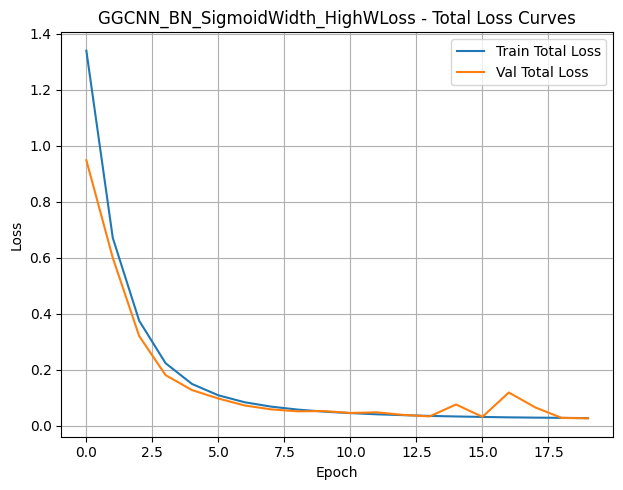


Finished training for GGCNN_BN_SigmoidWidth_HighWLoss.
Best model weights saved at: GGCNN_BN_SigmoidWidth_HighWLoss_best.pth
Best Validation Loss: 0.0267 at epoch 20
  Corresponding Train Loss: 0.0274
  Components at best val epoch (Q, Ang, W_norm): 0.0127, 0.0032, 0.0011


In [33]:
# Commented out for reruns
#-------------
# Hyperparameters
LEARNING_RATE_M1_NORM_W = 1e-3 
NUM_EPOCHS_M1_NORM_W = 20
PATIENCE_M1_NORM_W = 5       # Patience for early stopping

print(f"\nInstantiated {model1_name_eval} on device: {DEVICE}")
print(f"This model predicts NORMALIZED width [0,1] using Sigmoid.")

# Call the training loop with the loss function expecting normalized width
print(f"Using loss function 'compute_ggcnn_loss_updated_width_weight' (w_width = 10.0, expecting normalized width targets & preds)")

history_m1_final, best_model1_final_path = training_loop(
    model=model1_eval_instance,
    model_name=model1_name_eval,
    train_loader=train_loader, # Assumes train_loader yields normalized width maps
    val_loader=val_loader,     # Assumes val_loader yields normalized width maps
    loss_fn=compute_ggcnn_loss_updated_width_weight, 
    learning_rate=LEARNING_RATE_M1_NORM_W,
    epochs=NUM_EPOCHS_M1_NORM_W,
    device=DEVICE,
    patience=PATIENCE_M1_NORM_W
)

# Plot loss curves
plot_loss_curves(history_m1_final, model_name=model1_name_eval)

print(f"\nFinished training for {model1_name_eval}.")
print(f"Best model weights saved at: {best_model1_final_path}")
if history_m1_final['train_loss']:
    best_val_epoch_idx = np.argmin(history_m1_final['val_loss'])
    print(f"Best Validation Loss: {history_m1_final['val_loss'][best_val_epoch_idx]:.4f} at epoch {best_val_epoch_idx+1}")
    print(f"  Corresponding Train Loss: {history_m1_final['train_loss'][best_val_epoch_idx]:.4f}")
    print(f"  Components at best val epoch (Q, Ang, W_norm): {history_m1_final['val_q_loss'][best_val_epoch_idx]:.4f}, {history_m1_final['val_ang_loss'][best_val_epoch_idx]:.4f}, {history_m1_final['val_w_loss'][best_val_epoch_idx]:.4f}")
else:
    print("No training epochs were completed.")


Loading best weights for GGCNN_BN_SigmoidWidth_HighWLoss for validation visualization...
Best weights loaded.

Visualizing Predictions with GT (UNNORM width, first 1 from a batch)
Using quality_thresh_vis = 0.25 for displaying predicted grasps.

Visualizing Sample 1 (05/0513):
  Predicted Grasp Quality (Sigmoid): 0.3924
  Predicted Width (Un-normalized): 13.8px


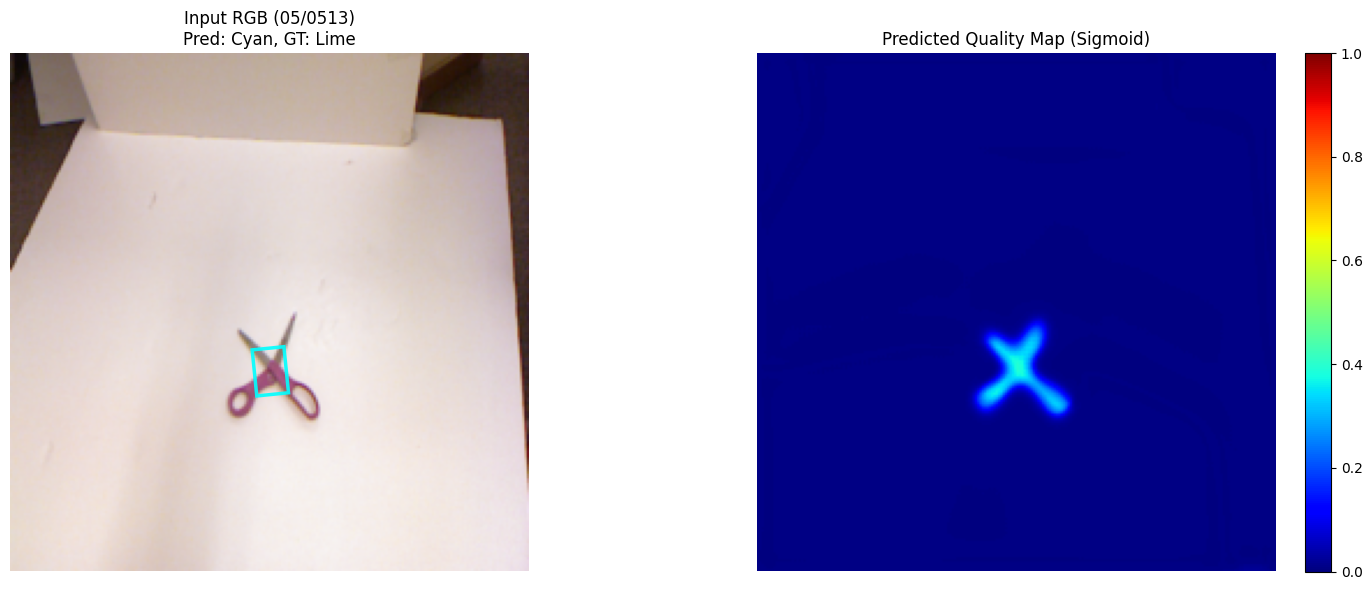

In [34]:
print(f"\nLoading best weights for {model1_name_eval} for validation visualization...")
if best_model1_path_eval.exists():
    model1_eval_instance.load_state_dict(torch.load(best_model1_path_eval, map_location=DEVICE))
    print("Best weights loaded.")

    visualize_predictions_with_gt(
        model_instance=model1_eval_instance, 
        data_loader_vis=val_loader,
        current_device=DEVICE, 
        num_samples_vis=1,
        quality_thresh_vis_val=0.25,
        max_pixel_width_for_unnorm_vis=MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED
    )
else:
    print(f"Best weights file not found for {model1_name_eval}. Cannot visualize on validation set.")

## 6.2. Training Model 2 (Improved GG-CNN)

In [35]:
model2_trained_instance = GGCNN_Improved(input_channels=4, output_channels=4).to(DEVICE)
model2_trained_instance_name = "GGCNN_Improved_SE_SigmoidWidth_HighWLoss"
best_model2_path = PREPROCESSED_DATA_DIR.parent / f"{model2_trained_instance_name}_best.pth"


Instantiated GGCNN_Improved_SE_SigmoidWidth_HighWLoss on device: mps
This model uses SE blocks, increased channels, and predicts NORMALIZED width [0,1].
Using loss function 'compute_ggcnn_loss_updated_width_weight' (w_width = 10.0, expecting normalized width)

Starting training for GGCNN_Improved_SE_SigmoidWidth_HighWLoss...


Epoch 1 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 [73.45s]:
  Train Loss: 1.3679 (Q:0.4624, Ang:0.2716, W:0.0634)
  Val   Loss: 1.0841 (Q:0.3774, Ang:0.1431, W:0.0564)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 1.0841)


Epoch 2 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 [74.28s]:
  Train Loss: 0.4508 (Q:0.2293, Ang:0.0158, W:0.0206)
  Val   Loss: 0.3100 (Q:0.1622, Ang:0.0105, W:0.0137)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.3100)


Epoch 3 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 [72.92s]:
  Train Loss: 0.1668 (Q:0.0976, Ang:0.0047, W:0.0065)
  Val   Loss: 0.1144 (Q:0.0687, Ang:0.0038, W:0.0042)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.1144)


Epoch 4 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 [73.00s]:
  Train Loss: 0.0853 (Q:0.0512, Ang:0.0034, W:0.0031)
  Val   Loss: 0.1218 (Q:0.0650, Ang:0.0063, W:0.0050)
    Val loss did not improve. Count: 1/5


Epoch 5 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 [72.92s]:
  Train Loss: 0.0572 (Q:0.0333, Ang:0.0033, W:0.0021)
  Val   Loss: 0.0587 (Q:0.0337, Ang:0.0037, W:0.0021)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0587)


Epoch 6 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 [73.74s]:
  Train Loss: 0.0447 (Q:0.0249, Ang:0.0033, W:0.0016)
  Val   Loss: 0.0443 (Q:0.0245, Ang:0.0035, W:0.0016)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0443)


Epoch 7 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 [72.94s]:
  Train Loss: 0.0379 (Q:0.0203, Ang:0.0033, W:0.0014)
  Val   Loss: 0.0862 (Q:0.0437, Ang:0.0092, W:0.0033)
    Val loss did not improve. Count: 1/5


Epoch 8 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 [72.87s]:
  Train Loss: 0.0337 (Q:0.0174, Ang:0.0033, W:0.0013)
  Val   Loss: 0.0397 (Q:0.0207, Ang:0.0040, W:0.0015)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0397)


Epoch 9 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 [72.83s]:
  Train Loss: 0.0307 (Q:0.0154, Ang:0.0032, W:0.0012)
  Val   Loss: 0.0326 (Q:0.0166, Ang:0.0033, W:0.0013)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0326)


Epoch 10 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 [73.21s]:
  Train Loss: 0.0293 (Q:0.0143, Ang:0.0033, W:0.0012)
  Val   Loss: 0.0355 (Q:0.0175, Ang:0.0036, W:0.0014)
    Val loss did not improve. Count: 1/5


Epoch 11 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 [73.18s]:
  Train Loss: 0.0276 (Q:0.0132, Ang:0.0032, W:0.0011)
  Val   Loss: 0.0815 (Q:0.0464, Ang:0.0051, W:0.0030)
    Val loss did not improve. Count: 2/5


Epoch 12 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 [73.18s]:
  Train Loss: 0.0265 (Q:0.0124, Ang:0.0032, W:0.0011)
  Val   Loss: 0.0435 (Q:0.0232, Ang:0.0041, W:0.0016)
    Val loss did not improve. Count: 3/5


Epoch 13 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 [73.07s]:
  Train Loss: 0.0256 (Q:0.0119, Ang:0.0032, W:0.0011)
  Val   Loss: 0.1010 (Q:0.0571, Ang:0.0062, W:0.0038)
    Val loss did not improve. Count: 4/5


Epoch 14 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 [72.97s]:
  Train Loss: 0.0249 (Q:0.0114, Ang:0.0031, W:0.0010)
  Val   Loss: 0.0280 (Q:0.0133, Ang:0.0034, W:0.0011)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0280)


Epoch 15 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 [73.20s]:
  Train Loss: 0.0242 (Q:0.0110, Ang:0.0031, W:0.0010)
  Val   Loss: 0.0275 (Q:0.0132, Ang:0.0034, W:0.0011)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0275)


Epoch 16 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 [73.15s]:
  Train Loss: 0.0238 (Q:0.0107, Ang:0.0031, W:0.0010)
  Val   Loss: 0.0266 (Q:0.0123, Ang:0.0034, W:0.0011)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0266)


Epoch 17 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 [73.12s]:
  Train Loss: 0.0237 (Q:0.0105, Ang:0.0032, W:0.0010)
  Val   Loss: 0.1371 (Q:0.0733, Ang:0.0073, W:0.0057)
    Val loss did not improve. Count: 1/5


Epoch 18 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 [73.14s]:
  Train Loss: 0.0232 (Q:0.0102, Ang:0.0031, W:0.0010)
  Val   Loss: 0.0224 (Q:0.0097, Ang:0.0031, W:0.0010)
    => Best model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth (Val Loss: 0.0224)


Epoch 19 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 [73.24s]:
  Train Loss: 0.0227 (Q:0.0099, Ang:0.0031, W:0.0010)
  Val   Loss: 0.0341 (Q:0.0170, Ang:0.0044, W:0.0013)
    Val loss did not improve. Count: 1/5


Epoch 20 Train:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 Val  :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 [73.13s]:
  Train Loss: 0.0226 (Q:0.0098, Ang:0.0031, W:0.0010)
  Val   Loss: 0.2814 (Q:0.1302, Ang:0.0191, W:0.0132)
    Val loss did not improve. Count: 2/5
Training finished for GGCNN_Improved_SE_SigmoidWidth_HighWLoss.
Best validation loss: 0.0224. Model saved to GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth


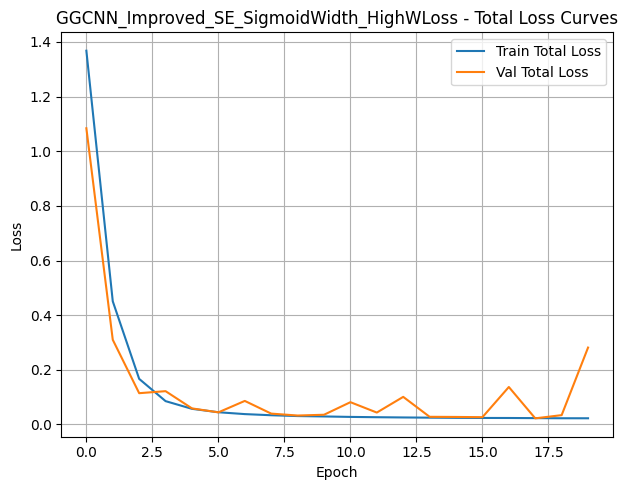


Finished training for GGCNN_Improved_SE_SigmoidWidth_HighWLoss.
Best model weights saved at: GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth
Best Validation Loss for Model 2: 0.0224 at epoch 18
  Corresponding Train Loss: 0.0232
  Components at best val epoch (Q, Ang, W_norm): 0.0097, 0.0031, 0.0010


In [36]:
# # Commented out for reruns
# #-------------
# Hyperparameters for Model 2
LEARNING_RATE_M2 = 1e-3
NUM_EPOCHS_M2 = 20
PATIENCE_M2 = 5

print(f"\nInstantiated {model2_trained_instance_name} on device: {DEVICE}")
print(f"This model uses SE blocks, increased channels, and predicts NORMALIZED width [0,1].")

# Call the training loop
print(f"Using loss function 'compute_ggcnn_loss_updated_width_weight' (w_width = 10.0, expecting normalized width)")

history_m2, best_model2_path = training_loop(
    model=model2_trained_instance,
    model_name=model2_trained_instance_name,
    train_loader=train_loader, # Ensure this loader yields normalized width maps
    val_loader=val_loader,     # Ensure this loader yields normalized width maps
    loss_fn=compute_ggcnn_loss_updated_width_weight, 
    learning_rate=LEARNING_RATE_M2,
    epochs=NUM_EPOCHS_M2,
    device=DEVICE,
    patience=PATIENCE_M2
)

# Plot loss curves
plot_loss_curves(history_m2, model_name=model2_trained_instance_name)

print(f"\nFinished training for {model2_trained_instance_name}.")
print(f"Best model weights saved at: {best_model2_path}")
if history_m2['train_loss']: # Check if training actually ran
    best_val_epoch_idx_m2 = np.argmin(history_m2['val_loss'])
    print(f"Best Validation Loss for Model 2: {history_m2['val_loss'][best_val_epoch_idx_m2]:.4f} at epoch {best_val_epoch_idx_m2+1}")
    print(f"  Corresponding Train Loss: {history_m2['train_loss'][best_val_epoch_idx_m2]:.4f}")
    print(f"  Components at best val epoch (Q, Ang, W_norm): {history_m2['val_q_loss'][best_val_epoch_idx_m2]:.4f}, {history_m2['val_ang_loss'][best_val_epoch_idx_m2]:.4f}, {history_m2['val_w_loss'][best_val_epoch_idx_m2]:.4f}")
else:
    print("No training epochs were completed for Model 2.")


Loading best weights for GGCNN_Improved_SE_SigmoidWidth_HighWLoss for validation visualization...
Best weights loaded for Model 2.

Visualizing SCALED Predictions with GT (first 1 from a batch)

Visualizing Sample 1 (05/0513):
  Pred Quality: 0.4747, Pred Width (orig space): 50.2px


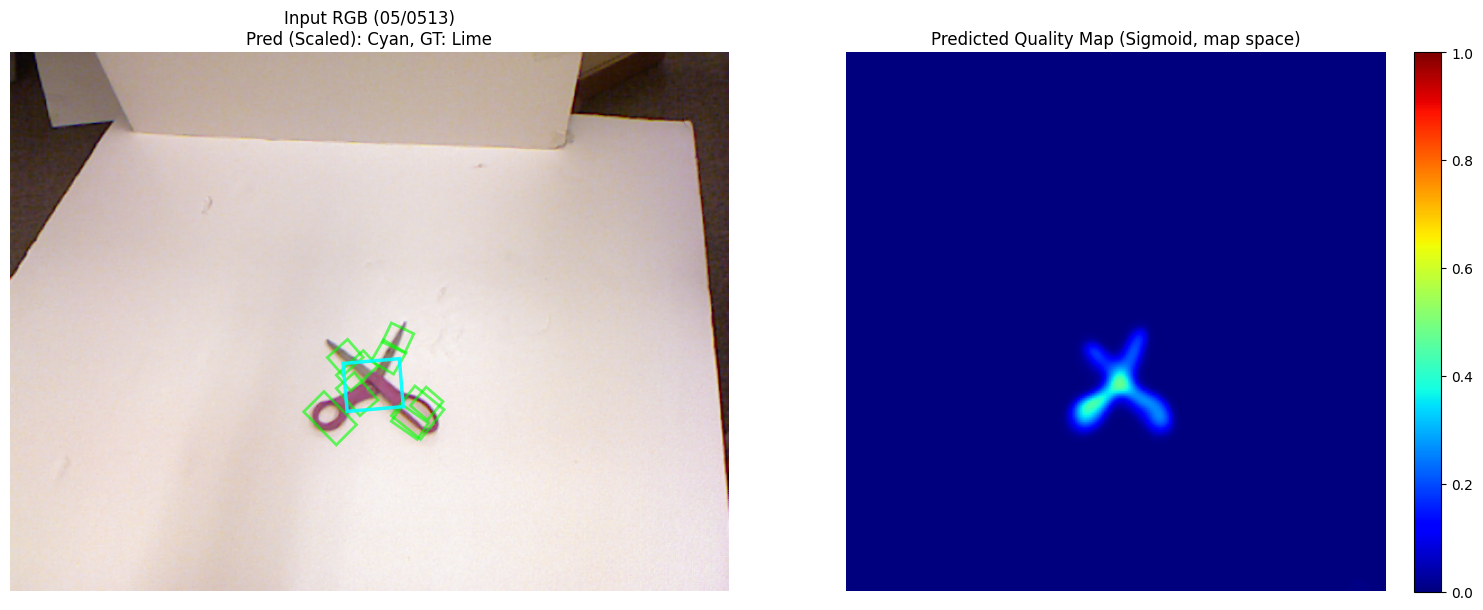

In [37]:
if best_model2_path.exists():
    print(f"\nLoading best weights for {model2_trained_instance_name} for validation visualization...")
    model2_trained_instance.load_state_dict(torch.load(best_model2_path, map_location=DEVICE))
    print("Best weights loaded for Model 2.")
    
    visualize_predictions_with_gt_scaled(
        model_instance=model2_trained_instance, 
        data_loader_vis=val_loader,
        current_device=DEVICE, 
        num_samples_vis=1,
        quality_thresh_vis_val=0.25,
        max_pixel_width_for_unnorm_vis=MAX_EXPECTED_PIXEL_WIDTH_NORMALIZED
    )
else:
    print(f"Best weights file not found for {model2_trained_instance_name}. Cannot visualize on validation set.")

# 7 Test Set

## 7.1. Final Evaluation on Test Set

In [38]:
# Model 1 (GGCNN_BN_SigmoidWidth_HighWLoss - from 20 epoch training)
model1_eval_name = "GGCNN_BN_SigmoidWidth_HighWLoss" 
best_model1_path_eval = PREPROCESSED_DATA_DIR.parent / f"{model1_eval_name}_best.pth"
model1_eval_instance = GGCNN_Baseline_BN_SigmoidWidth(input_channels=4, output_channels=4).to(DEVICE)
final_success_rate_m1 = -1.0 # Default if not evaluated

if best_model1_path_eval.exists():
    print(f"\nLoading best weights for {model1_eval_name} from {best_model1_path_eval}")
    model1_eval_instance.load_state_dict(torch.load(best_model1_path_eval, map_location=DEVICE))
    print(f"Best weights loaded for {model1_eval_name}.")

    print(f"\nRunning FINAL evaluation on TEST SET for {model1_eval_name}")
    final_success_rate_m1 = run_final_evaluation_metric( # Use the clean evaluation function
        model_instance=model1_eval_instance,
        test_data_loader=test_loader, 
        current_device=DEVICE,
        angle_diff_threshold_deg_val=30.0,
    )
else:
    print(f"Model weights for {model1_eval_name} not found at {best_model1_path_eval}. Skipping its evaluation.")


# Model 2 (GGCNN_Improved_SE_SigmoidWidth_HighWLoss)
model2_eval_name = "GGCNN_Improved_SE_SigmoidWidth_HighWLoss" 
best_model2_path_eval = PREPROCESSED_DATA_DIR.parent / f"{model2_eval_name}_best.pth"
model2_eval_instance = GGCNN_Improved(input_channels=4, output_channels=4).to(DEVICE)
final_success_rate_m2 = -1.0 # Default if not evaluated

if best_model2_path_eval.exists():
    print(f"\nLoading best weights for {model2_eval_name} from {best_model2_path_eval}")
    model2_eval_instance.load_state_dict(torch.load(best_model2_path_eval, map_location=DEVICE))
    print(f"Best weights loaded for {model2_eval_name}.")

    print(f"\nRunning FINAL evaluation on TEST SET for {model2_eval_name}")
    final_success_rate_m2 = run_final_evaluation_metric(
        model_instance=model2_eval_instance,
        test_data_loader=test_loader,
        current_device=DEVICE,
        angle_diff_threshold_deg_val=30.0,
    )
else:
    print(f"Model weights for {model2_eval_name} not found at {best_model2_path_eval}. Skipping its evaluation.")

# Summary of Final Test Success Rates
print("\nSummary of Final Test Success Rates")
print(f"Model 1 ({model1_eval_name}): {final_success_rate_m1*100:.2f}%" if final_success_rate_m1 != -1.0 else f"Model 1 ({model1_eval_name}): Not Evaluated")
print(f"Model 2 ({model2_eval_name}): {final_success_rate_m2*100:.2f}%" if final_success_rate_m2 != -1.0 else f"Model 2 ({model2_eval_name}): Not Evaluated")


Loading best weights for GGCNN_BN_SigmoidWidth_HighWLoss from GGCNN_BN_SigmoidWidth_HighWLoss_best.pth
Best weights loaded for GGCNN_BN_SigmoidWidth_HighWLoss.

Running FINAL evaluation on TEST SET for GGCNN_BN_SigmoidWidth_HighWLoss


Final Metric Eval:   0%|          | 0/6 [00:00<?, ?it/s]


Final Metric Results
Model Evaluated: GGCNN_Baseline_BN_SigmoidWidth
Total Test Images: 88
Images with any prediction above quality threshold (0.25): 87
Successful Grasps (IoU > 0.25 AND Symm. AngleDiff < 30.0deg): 41
GRASP SUCCESS RATE: 46.59%

Loading best weights for GGCNN_Improved_SE_SigmoidWidth_HighWLoss from GGCNN_Improved_SE_SigmoidWidth_HighWLoss_best.pth
Best weights loaded for GGCNN_Improved_SE_SigmoidWidth_HighWLoss.

Running FINAL evaluation on TEST SET for GGCNN_Improved_SE_SigmoidWidth_HighWLoss


Final Metric Eval:   0%|          | 0/6 [00:00<?, ?it/s]


Final Metric Results
Model Evaluated: GGCNN_Improved
Total Test Images: 88
Images with any prediction above quality threshold (0.25): 85
Successful Grasps (IoU > 0.25 AND Symm. AngleDiff < 30.0deg): 39
GRASP SUCCESS RATE: 44.32%

Summary of Final Test Success Rates
Model 1 (GGCNN_BN_SigmoidWidth_HighWLoss): 46.59%
Model 2 (GGCNN_Improved_SE_SigmoidWidth_HighWLoss): 44.32%


## 7.2 Visualizations of Models

Added GGCNN_BN_SigmoidWidth_HighWLoss (already loaded) for multi-visualization.
Added GGCNN_Improved_SE_SigmoidWidth_HighWLoss (already loaded) for multi-visualization.

Visualizing Predictions for Multiple Models (first 3 from a batch)
Using quality_thresh_vis = 0.2 for displaying predicted grasps.

Visualizing Sample 1 (05/0589):
  Model: GGCNN_BN_SigmoidWidth_HighWLoss - Pred Quality: 0.3837, Pred Width (orig space): 39.1px
  Model: GGCNN_Improved_SE_SigmoidWidth_HighWLoss - Pred Quality: 0.4106, Pred Width (orig space): 42.6px


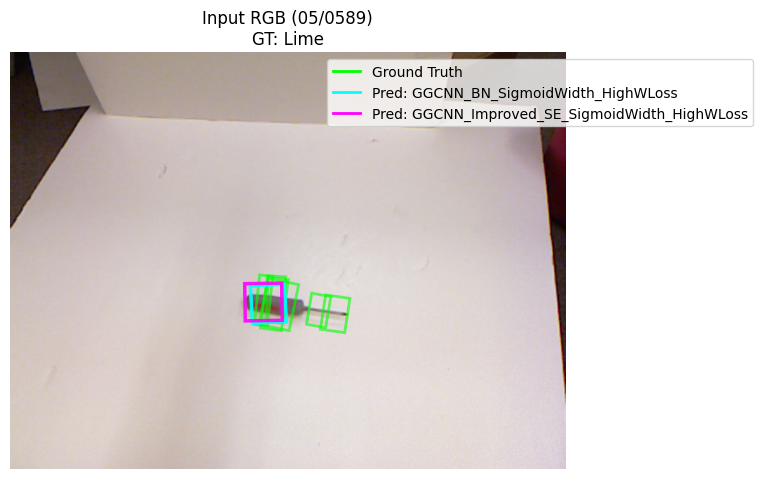


Visualizing Sample 2 (01/0105):
  Model: GGCNN_BN_SigmoidWidth_HighWLoss - Pred Quality: 0.4219, Pred Width (orig space): 42.6px
  Model: GGCNN_Improved_SE_SigmoidWidth_HighWLoss - Pred Quality: 0.4468, Pred Width (orig space): 46.6px


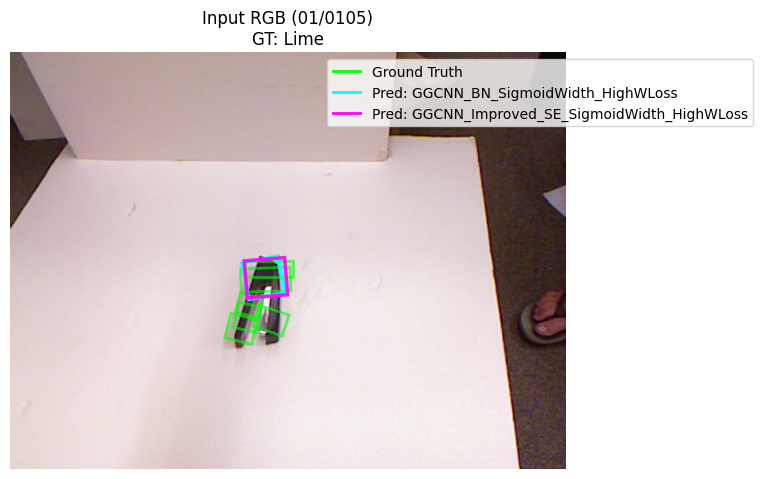


Visualizing Sample 3 (03/0334):
  Model: GGCNN_BN_SigmoidWidth_HighWLoss - Pred Quality: 0.3908, Pred Width (orig space): 39.0px
  Model: GGCNN_Improved_SE_SigmoidWidth_HighWLoss - Pred Quality: 0.4603, Pred Width (orig space): 46.8px


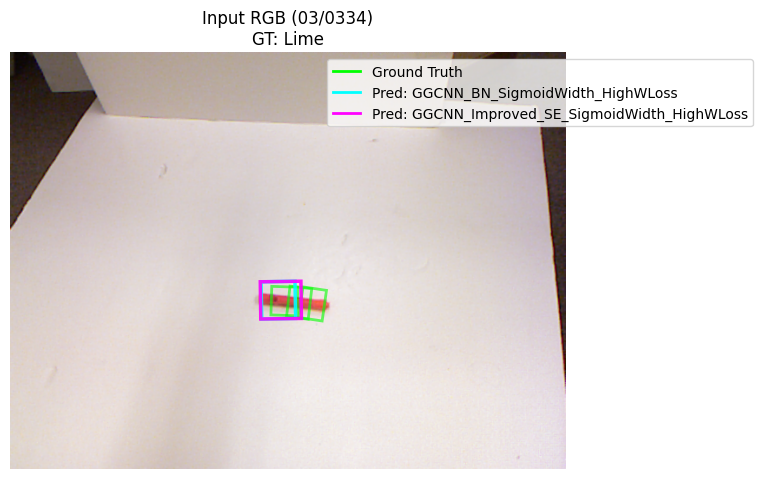

In [39]:
models_to_visualize = {}
model_colors = {}

# Load Model 1 (GGCNN_BN_SigmoidWidth_HighWLoss)
# model1_eval_name and best_model1_path_eval are from the cell above
if best_model1_path_eval.exists():
    # We can reuse model1_eval_instance if it's still in scope and loaded,
    # or create/load a fresh one for strict separation. Let's assume it's loaded.
    if 'model1_eval_instance' in locals() and model1_eval_instance is not None:
        models_to_visualize[model1_eval_name] = model1_eval_instance
        model_colors[model1_eval_name] = 'cyan' 
        print(f"Added {model1_eval_name} (already loaded) for multi-visualization.")
    else: # Fallback to load if not already loaded
        temp_model1 = GGCNN_Baseline_BN_SigmoidWidth(input_channels=4, output_channels=4).to(DEVICE)
        temp_model1.load_state_dict(torch.load(best_model1_path_eval, map_location=DEVICE))
        models_to_visualize[model1_eval_name] = temp_model1
        model_colors[model1_eval_name] = 'cyan'
        print(f"Loaded {model1_eval_name} for multi-visualization.")
else:
    print(f"Weights for {model1_eval_name} not found. It will be skipped in visualization.")


# Load Model 2 (GGCNN_Improved_SE_SigmoidWidth_HighWLoss)
# model2_eval_name and best_model2_path_eval are from the cell above
if best_model2_path_eval.exists():
    if 'model2_eval_instance' in locals() and model2_eval_instance is not None:
        models_to_visualize[model2_eval_name] = model2_eval_instance
        model_colors[model2_eval_name] = 'magenta' 
        print(f"Added {model2_eval_name} (already loaded) for multi-visualization.")
    else: # Fallback
        temp_model2 = GGCNN_Improved(input_channels=4, output_channels=4).to(DEVICE)
        temp_model2.load_state_dict(torch.load(best_model2_path_eval, map_location=DEVICE))
        models_to_visualize[model2_eval_name] = temp_model2
        model_colors[model2_eval_name] = 'magenta'
        print(f"Loaded {model2_eval_name} for multi-visualization.")
else:
    print(f"Weights for {model2_eval_name} not found. It will be skipped in visualization.")



# Run Multi-Model Visualization
if models_to_visualize:
    visualize_multiple_model_predictions(
        models_dict=models_to_visualize,
        colors_dict=model_colors,
        data_loader_vis=test_loader, # Visualize on the test set
        current_device=DEVICE,
        num_samples_vis=3, # Show a few samples for comparison
        quality_thresh_vis_val=0.2 # Use a slightly lower threshold to see more potential predictions
    )
else:
    print("No models loaded for multi-visualization.")